## Goals:

- load the G from layers for miniaste
- create the G_advh from offline monthly avg.
- load the gateways (make sure indices)
- verify this way
- now verify the M term

## setup

In [1]:
# auto-reload edited modules
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.insert(0, "/home/mmurakami/crios_backups/an_helper_functions")

# run the script into the curre nt kernel (vars/functions become available)
%run -i "/home/mmurakami/crios_backups/an_helper_functions/prep_grid_aste_90.py"

(450, 90)
RAC2d (40500,)
(100,)


In [2]:
dirroot = "/scratch3/atnguyen/aste_90x150x60/"
dirgrid = dirroot + "GRID_real8/"
dirgridnb = dirroot + "GRID_noblank/"
runstr= "run_c68v_heffmosm3x_layers_lessmem1_viscAHp5em2_it0000_pk0000000001/"
layers_path = dirroot + runstr
extL = "LAYERS"
dirmask = dirroot + "run_template/input_maskTransport/"
dirbudg = layers_path + "diags/BUDG/"
dirdiags = dirbudg
dirstate = layers_path + "diags/STATE/"
dirlayers = layers_path + "diags/LAYERS/"
dirtrsp = layers_path + "diags/TRSP/"

In [3]:
# maybe we can dump a file to load the aste90 grid so I can have all the values

In [4]:
# try to use rdmds
fileprefix = "/scratch3/atnguyen/aste_90x150x60/"
extBasin='run_template/input_maskTransport/'
filename = fileprefix + extBasin + "GATE_transports_v2_mskBasin.bin"
ind = np.fromfile(filename, dtype=np.int32)  # auto-reads .meta for shape/dtype/order
orig_shape = (ind.shape)

ind2d = ind.reshape(ny,nx)

mymsk = np.full((ny,nx),np.nan)
mymsk[ind2d == 57408.0] = 1

# make this smaller
mymsk[:,27:50] = np.nan
mymsk[:160,12:30] = np.nan
mymsk[160:163,15:30] = np.nan

ind = ind.reshape(ny,nx)
mymsk = np.full((ny,nx),np.nan)
mymsk[ind == 57408.0] = 1

# make this smaller
mymsk[:,27:50] = np.nan
mymsk[:160,12:30] = np.nan
mymsk[160:163,15:30] = np.nan

In [5]:
landmsk = np.zeros((ny,nx))
landmsk[hf1 == 0] = 1
landmsk[hf1 == 1] = np.nan

In [6]:
ysmsk,xsmsk = np.where(mymsk==1)[0],np.where(mymsk==1)[1]

In [7]:
# define the gates for the miniaste

# these are the indices we want to read from, but not write to
# at y = 186, we want -ADVy
x_bsoh = np.array([54, 54, 54, 54, 54])
x_bsov = np.array([0,  1,  2,  3,  4,  5,  6,  7,  8,  9])    # from Norway to Sp
y_bsoh = np.array([145, 146, 147, 148, 149])
y_bsov = np.array([186, 186, 186, 186, 186, 186, 186, 186, 186, 186])    # from Norway to Sp

x_spfjh = np.array([20,20,20,23,24,24,26,26])    # vertical gates from Sp to Fj as -x
y_spfjh = np.array([185,184,183,182,181,180,179,178])
x_spfjv = np.array([20,21,22,23,24,25,26])          # horizontal gates where we want to read -y
y_spfjv = np.array([183,183,183,183,182,180,180])

y_fjnzv = np.arange(165,175,1)
x_fjnzv = np.full_like(y_fjnzv,27)    # horizontal gate where we want to read -x

y_nzruv = np.arange(152,155,1)
x_nzruv = np.full_like(y_nzruv,12)   # horizontal gate where we want to read -x

In [8]:
# gates_mask starts as NaN everywhere
gates_mask = np.full((ny, nx), np.nan, dtype=float)

def _mark_points(mask, xs, ys, code, ny, nx, name="gate"):
    """
    Mark (y, x) points in mask with 'code'.
    If a point already has a different non-NaN code, set it to 3 (overlap).
    Bounds are clipped to the grid silently.
    """
    xs = np.asarray(xs)
    ys = np.asarray(ys)

    if xs.shape != ys.shape:
        raise ValueError(f"{name}: x/y length mismatch: {xs.shape} vs {ys.shape}")

    # clip to valid indices just in case
    xi = np.clip(xs.astype(int), 0, nx-1)
    yi = np.clip(ys.astype(int), 0, ny-1)

    for j, i in zip(yi, xi):
        cur = mask[j, i]
        if np.isnan(cur):
            mask[j, i] = code
        elif cur == code or cur == 3:
            # already same code or already overlap — leave as is
            continue
        else:
            mask[j, i] = 3  # overlap with different code
    return mask

# ---- mark H gates with code = 1 ----
gates_mask = _mark_points(gates_mask, x_bsoh, y_bsoh, 1, ny, nx, name="bsoh")
gates_mask = _mark_points(gates_mask, x_spfjh, y_spfjh, 1, ny, nx, name="spfjh")

# ---- mark V gates with code = 2 ----
gates_mask = _mark_points(gates_mask, x_bsov,  y_bsov,  2, ny, nx, name="bsov")
gates_mask = _mark_points(gates_mask, x_spfjv, y_spfjv, 2, ny, nx, name="spfjv")
gates_mask = _mark_points(gates_mask, x_fjnzv, y_fjnzv, 1, ny, nx, name="fjnzv")
gates_mask = _mark_points(gates_mask, x_nzruv, y_nzruv, 1, ny, nx, name="nzruv")

# Optional: if you prefer 0 instead of NaN for “not a gate”
# gates_mask = np.nan_to_num(gates_mask, nan=0.0)

In [9]:
# let's make a mask of these to double check that we did this correctly

gates_mask[182,23] = 3
gates_mask[180,24] = 3 
gates_mask[180,26] = np.nan
gates_mask[182,24] = np.nan
gates_mask[183,23] = np.nan

In [10]:
mymsk_1d = mymsk.reshape(orig_shape, order='C')
mymsk3d = np.tile(mymsk[np.newaxis,:,:],(nz,1,1))

(140.0, 200.0)

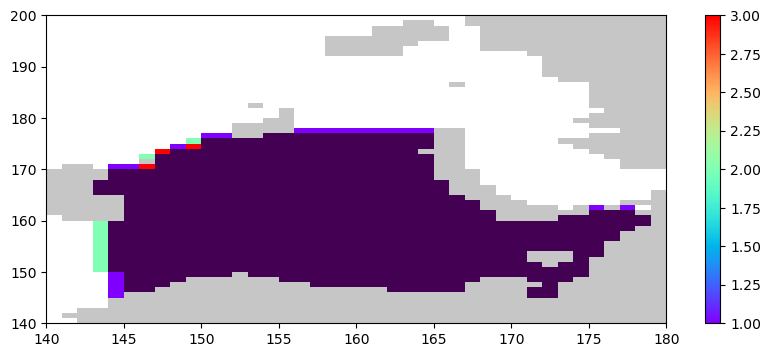

In [11]:
# again the gates are the indices we want to read from, but not write to! I think An is mistaken by how I defined these
# we can try to prove this with the ADVh
plt.pcolormesh(get_aste_tracer(mymsk,nfx,nfy)[0])
plt.pcolormesh(get_aste_tracer(gates_mask,nfx,nfy)[0],cmap='rainbow')
plt.colorbar()
plt.pcolormesh(get_aste_tracer(landmsk,nfx,nfy)[0],cmap="Greys",vmin=-2,vmax=4)
plt.xlim(140,180)
plt.ylim(140,200)

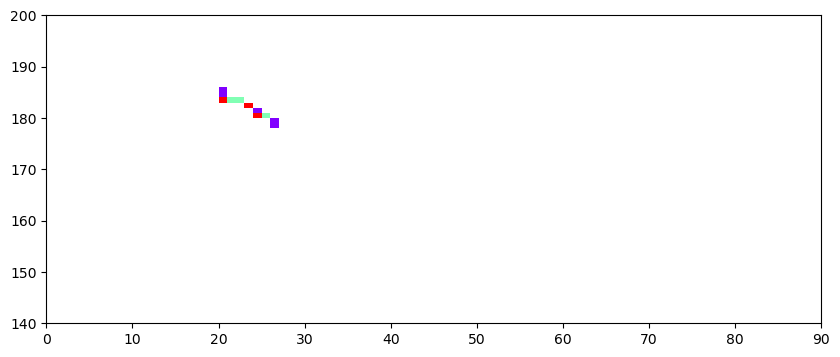

In [12]:
testmsk = gates_mask.copy()
testmsk[:,:19] = np.nan
testmsk[:,30:] = np.nan
testmsk[:178,:] = np.nan

plt.pcolormesh(testmsk,cmap='rainbow')
# plt.pcolormesh(get_aste_tracer(testmsk,nfx,nfy)[0],cmap='rainbow')
# plt.xlim(140,180)
plt.ylim(140,200)
y_spfjv2,x_spfjv2 = np.where(testmsk == 2)[0],np.where(testmsk == 2)[1]
y_spfjh2,x_spfjh2 = np.where(testmsk == 1)[0],np.where(testmsk == 1)[1]
y_spfjb2,x_spfjb2 = np.where(testmsk == 3)[0],np.where(testmsk == 3)[1]

In [13]:
print(y_spfjv2)

[180 183 183]


(175.0, 190.0)

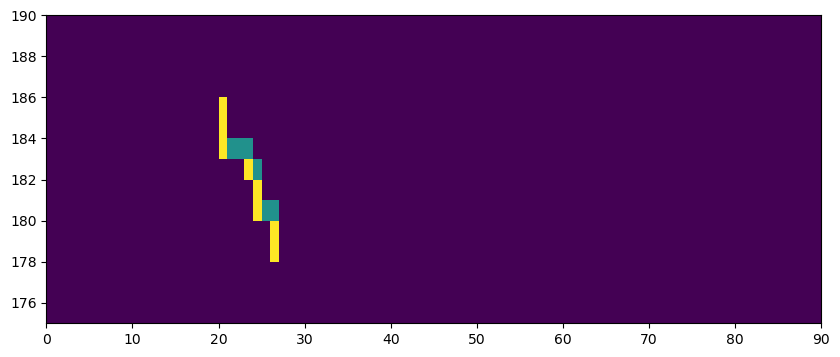

In [14]:
testmsk = np.zeros_like(gates_mask)
testmsk[y_spfjv,x_spfjv] = 1
testmsk[y_spfjh,x_spfjh] = 2
plt.pcolormesh(testmsk)
plt.ylim(175,190)

In [15]:
print(y_spfjv2,x_spfjv2)
print(y_spfjv,x_spfjv)

[180 183 183] [25 21 22]
[183 183 183 183 182 180 180] [20 21 22 23 24 25 26]


In [16]:
# build gate mask
gates_msk = np.full((ny, nx), np.nan)
for j, i in zip(y_bso_all,  x_bso_all):
    gates_msk[j, i] = 1
for j, i in zip(y_spfj_all, x_spfj_all):
    gates_msk[j, i] = 2
for j, i in zip(y_fjnz_all, x_fjnz_all):
    gates_msk[j, i] = 3
for j, i in zip(y_nzru_all, x_nzru_all):
    gates_msk[j, i] = 4

# ASTE regridding
depth_aste = get_aste_tracer(mygrid["Depth"], nfx, nfy)[0]
land_aste  = get_aste_tracer(landmsk,        nfx, nfy)[0]
mymsk_aste = get_aste_tracer(mymsk,          nfx, nfy)[0]
gates_aste = get_aste_tracer(gates_msk,      nfx, nfy)[0]

fig, ax = plt.subplots(figsize=(6, 6))

# background: depth
pc = ax.pcolormesh(depth_aste, cmap="Blues_r")

# land mask (e.g., >0 = land)
ax.pcolormesh(
    np.ma.masked_where(land_aste == 1, land_aste),
    cmap="Greys",
    alpha=0.4,
)

# your own mask
ax.pcolormesh(
    np.ma.masked_where(mymsk_aste == 0, mymsk_aste),
    cmap="Reds",
    alpha=0.3,
)

# gate mask, with distinct colors per gate
gate_cmap = ListedColormap(["none", "tab:blue", "tab:orange", "tab:green", "tab:purple"])
ax.pcolormesh(
    np.ma.masked_invalid(gates_aste),
    cmap=gate_cmap,
    alpha=0.9,
)

ax.set_aspect("equal")
ax.invert_yaxis()
ax.set_xlabel("x index")
ax.set_ylabel("y index")
ax.set_xlim(130,180)
ax.set_ylim(140,200)
fig.colorbar(pc, ax=ax, label="Depth (m)")

plt.tight_layout()


NameError: name 'y_bso_all' is not defined

## Make sure we have the bins

In [17]:
filename = "layers2TH"
boundsT = rdmds(layers_path + filename)
binsTH_edges = boundsT.reshape(boundsT.shape[0])
binsTH_centers = (binsTH_edges[:-1] + binsTH_edges[1:])/2
nT = binsTH_edges.shape[0]-1

filename = "layers1SLT"
boundsS = rdmds(layers_path + filename)
binsSLT_edges = boundsS.reshape(boundsS.shape[0])
binsSLT_centers = (binsSLT_edges[:-1] + binsSLT_edges[1:])/2
nS = binsSLT_edges.shape[0]-1

binwidthT = binsTH_edges[1:] - binsTH_edges[:-1]
binwidthS = binsSLT_edges[1:] - binsSLT_edges[:-1]

binwidthT1 = (binwidthT[:-1] + binwidthT[1:])/2
binwidthS1 = (binwidthS[:-1] + binwidthS[1:])/2

binmidT = ((boundsT[:-1] + boundsT[1:])/2).reshape(nT)
binmidS = ((boundsS[:-1] + boundsS[1:])/2).reshape(nT)

## Load the G_T and G_S terms

In [18]:
# we need to also create the theta and salt bins for this area
tsstr = np.array(["0000000002","0000000003"])
t2 = int(tsstr[1]) # for the offline version

In [19]:
mymsk_1d = mymsk.reshape(orig_shape, order='C')
mymsk_1dtile = np.tile(mymsk_1d[np.newaxis,:],(nT-1,1))
hf2dtile.shape

(111, 40500)

In [20]:
ffac=1e-6
G_T=np.array([])
metaT=parsemeta(layers_path + "diags/LAYERS/layers_3d_Ttend." + tsstr[1] + ".meta")
nFldsT = metaT["fldList"]
print(len(nFldsT))
setTtend=nFldsT.copy()
fldsIwant = np.array(['LaTh2TH','LaTz2TH'])

# check for the correct diagnostics
metaT['fldList']   # 13, 14, 15, 16, 19, 22
b = metaT['fldList']
ifldT = np.array([1,2])    # surf, hDiff, vDiff, hADV, vADV, total tend
# print(np.array(b)[ifldT])  # for G_T

# remake the following to look for the existing terms and see if we can recreate
# ['LaTs2TH' 'LaTh2TH' 'LaTz2TH' 'LTha2TH' 'LTza2TH' 'LTto2TH']
ifldT = np.array([0,1,2,7,8,11])
print(np.array(b)[ifldT])  # for G_T


# we will just do the exact same thing for all the terms
metaS=parsemeta(layers_path + "diags/LAYERS/layers_3d_Stend." + "0000000003" + ".meta")
nFldsS = metaS["fldList"]
print(len(nFldsT))
setStend=nFldsS.copy()

# check for the correct diagnostics
metaS['fldList']   # 13, 14, 15, 16, 19, 22
b = metaS['fldList']
# ['LaSs1SLT' 'LaSh1SLT' 'LaSz1SLT' 'LSha1SLT' 'LSza1SLT' 'LSto1SLT']
ifldS = np.array([12,13,14,19,20,23])

# print(b[12,13,14,19,20,23])
print(np.array(b)[ifldS])  # for G_S

24
['LaTs2TH' 'LaTh2TH' 'LaTz2TH' 'LTha2TH' 'LTza2TH' 'LTto2TH']
24
['LaSs1SLT' 'LaSh1SLT' 'LaSz1SLT' 'LSha1SLT' 'LSza1SLT' 'LSto1SLT']


In [21]:
# mymsk3d.shape
# hf2dtile.shape
iwet_mine = np.where(~np.isnan(mymsk_1d))
iwet_mine[0].shape
iwet_mine = iwet_mine[0]   # this is already the 1D array of wetpoints to use, we can add these below by indexing

In [22]:
# make the G_T term
# we did not mask this or the other one which is why they are the same
# try to make sure we maskt this here.

name = "BarentsS"
G_T = {}
G_T[name] = {}
ts = tsstr[1]
    
# now loop through
G_T[name][ts] = {}
for i in range(len(ifldT)-1, -1, -1):
    tmp = read_float64_skip(layers_path + "diags/LAYERS/layers_3d_Ttend." + tsstr[-1] + ".data", nx*ny*(nT-1),ifldT[i])
    tmp = np.reshape(tmp,(nT-1,nx*ny))
    tmp = tmp * (rac2dtile * hf2dtile) #* ffac

    if i == ifldT.shape[0]-1:
        # if LTto2TH, do not remove from residual
        residT = tmp
    else:
        # else if vADV, hADV, vDiff, hDiff, surface, remove from residual
        residT = residT-tmp
    
    # just do the Barents Sea for this one
    a = np.nansum(tmp[:,iwet_mine],axis=1)
    G_T[name][ts][setTtend[ifldT[i]]] = a

# residT was wrong here so we can just ignore

In [23]:
# let's try to verify with G_T first and then start with G_S
# make the G_T term
# we did not mask this or the other one which is why they are the same
# try to make sure we maskt this here.
metaS=parsemeta(layers_path + "diags/LAYERS/layers_3d_Stend." + "0000000003" + ".meta")
nFldsS = metaS["fldList"]
print(len(nFldsT))
setTtend=nFldsT.copy()
# check for the correct diagnostics
metaS['fldList']   # 13, 14, 15, 16, 19, 22
b = metaS['fldList']
# ['LaSs1SLT' 'LaSh1SLT' 'LaSz1SLT' 'LSha1SLT' 'LSza1SLT' 'LSto1SLT']
ifldS = np.array([12,13,14,19,20,23])

# print(b[12,13,14,19,20,23])
print(np.array(b)[ifldS])  # for G_S

# make the G_T term
G_S = {}
G_S["BarentsS"] = {}
    
# now loop through
G_S["BarentsS"][ts] = {}
for i in range(len(ifldS)-1, -1, -1):
    tmp = read_float64_skip(layers_path + "diags/LAYERS/layers_3d_Stend." + tsstr[-1] + ".data", nx*ny*(nS-1),ifldS[i])
    tmp = np.reshape(tmp,(nS-1,nx*ny))

    # here we will want to multiply by the mask for the Barents Sea
    tmp = tmp * mymsk_1dtile * (rac2dtile * hf2dtile) #* ffac

    if i == ifldS.shape[0]-1:
        # if LTto2TH, do not remove from residual
        residS = tmp
    else:
        # else if vADV, hADV, vDiff, hDiff, surface, remove from residual
        residS = residT-tmp
    
    # just do the Barents Sea for this one
    a = np.nansum(tmp[:,iwet_mine],axis=1)
    G_S["BarentsS"][ts][setTtend[ifldS[i]]] = a


24
['LaSs1SLT' 'LaSh1SLT' 'LaSz1SLT' 'LSha1SLT' 'LSza1SLT' 'LSto1SLT']


In [24]:
layers_path

'/scratch3/atnguyen/aste_90x150x60/run_c68v_heffmosm3x_layers_lessmem1_viscAHp5em2_it0000_pk0000000001/'

## Create the ADVh terms from the salt and temp

In [25]:
t2 = int(tsstr[1])
# 'diags/state_3d_set1'
# read theta and salt averages from the t2 timestep (average)
file_name = "state_3d_set1"
meta_state_3d_set1 = parsemeta(dirstate + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_state_3d_set1["fldList"])
varnames = np.array(["THETA","SALT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
THETA,its,meta = rdmds(os.path.join(dirstate, file_name),t2,returnmeta=True,rec=recs[0])
SALT,its,meta = rdmds(os.path.join(dirstate, file_name),t2,returnmeta=True,rec=recs[1])

THETA = THETA.reshape(nz,ny,nx)
SALT = SALT.reshape(nz,ny,nx)

In [26]:
file_name = "budg3d_hflux_set2"
meta_budg3d_hflux_set2 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_hflux_set2["fldList"])
varnames = np.array(["ADVx_TH","ADVy_TH"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVx_TH,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[0])
ADVy_TH,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[1])

# now 3d zfluxes
file_name = "budg3d_zflux_set1"
meta_budg3d_zflux_set1 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_zflux_set1["fldList"])
varnames = np.array(["ADVr_TH"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVr_TH,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[0])
ADVr_TH = ADVr_TH.reshape(nz,ny,nx)

hf = mygrid['hFacC']

ADV_hconv = calc_UV_conv_mod(nfx, nfy,get_aste_faces(ADVx_TH.reshape(nz, ny, nx), nfx, nfy),get_aste_faces(ADVy_TH.reshape(nz, ny, nx), nfx, nfy))
ADV_hconv = ADV_hconv * hf   # degC·m^3/s at cell centers (matches: ff.DFh = ff.DFh .* hf)
ADVhT = ADV_hconv

trWtopADV = -(ADVr_TH)

ADVrT = np.zeros((nz,ny,nx),dtype=float)
ADVrT[:-1,:,:] = (trWtopADV[:-1] - trWtopADV[1:])  # this is not the way we did it in the original code but this is the way An has done it so we try

In [27]:
dirdiags

'/scratch3/atnguyen/aste_90x150x60/run_c68v_heffmosm3x_layers_lessmem1_viscAHp5em2_it0000_pk0000000001/diags/BUDG/'

In [28]:
# load the bolus terms

file_name = "budg3d_hflux_layers_set1"
meta_budg3d_hflux_layers_set1 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_hflux_layers_set1["fldList"])
varnames = np.array(["lADVx_TH"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
lADBx_TH,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[0])

file_name = "budg3d_hflux_layers_set2"
meta_budg3d_hflux_layers_set2 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_hflux_layers_set2["fldList"])
varnames = np.array(["lADVy_TH"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
lADBy_TH,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[0])

file_name = "budg3d_zflux_layers_set1"
meta_budg3d_zflux_layers_set1 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_zflux_layers_set1["fldList"])
varnames = np.array(["lADBr_TH"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
lADBr_TH,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[0])

In [29]:
# reshaping

lADBx_TH = lADBx_TH.reshape(nz,ny,nx)
lADBy_TH = lADBy_TH.reshape(nz,ny,nx)

## verify these manually

In [30]:
def _bincount_sum_with_nan(idx, vals, nout):
    """
    NaN-aware per-bin sum:
    if *all* entries in a bin are NaN, that bin returns NaN;
    otherwise NaNs are ignored and finite values are summed.
    """
    # track counts of non-nan contributions
    finite = np.isfinite(vals)
    sums   = np.bincount(idx[finite], vals[finite], minlength=nout).astype(float)
    counts = np.bincount(idx[finite], None, minlength=nout).astype(float)
    out = sums
    out[counts == 0] = np.nan
    return out

In [31]:
G_advh_online = G_T[name][ts]['LTha2TH']
G_advr_online = G_T[name][ts]['LTza2TH']


# do this manually from ADVh
nT   = boundsT.size - 1
nTm1 = nT - 1
nS = boundsS.size -1 
nSm1 = nS - 1

# mask by the Barents Sea
ADVhT_BS = ADVhT * mymsk3d
ADVrT_BS = ADVrT * mymsk3d


# --- "new" interpretation: bin by binmidT intervals ---
theta_flat = THETA.ravel()
salt_flat = SALT.ravel()
ADVh_flat   = ADVhT_BS.ravel()
ADVr_flat   = ADVrT_BS.ravel()

# binmidT[i] <= THETA < binmidT[i+1], i=0..nT-2
bin_idx_mid = np.digitize(theta_flat, binmidT, right=False) - 1
valid_mid   = (bin_idx_mid >= 0) & (bin_idx_mid < nTm1) & np.isfinite(theta_flat)
idx_mid     = bin_idx_mid[valid_mid]
bin_idx_midS = np.digitize(salt_flat, binmidS, right=False) - 1
valid_midS  = (bin_idx_midS >= 0) & (bin_idx_midS < nSm1) & np.isfinite(salt_flat)
idx_midS     = bin_idx_midS[valid_midS]

# per-bin sums with NaN-propagation
ADVh_new = _bincount_sum_with_nan(idx_mid, ADVh_flat[valid_mid], nTm1)
ADVr_new = _bincount_sum_with_nan(idx_mid, ADVr_flat[valid_mid], nTm1)


# edge-based G (m^3/s): divide by edge binwidths
G_off_new_h = ADVh_new / binwidthT1
G_off_new_r = ADVr_new / binwidthT1

Text(0.5, 1.0, 'ADVh contrib to Temperature')

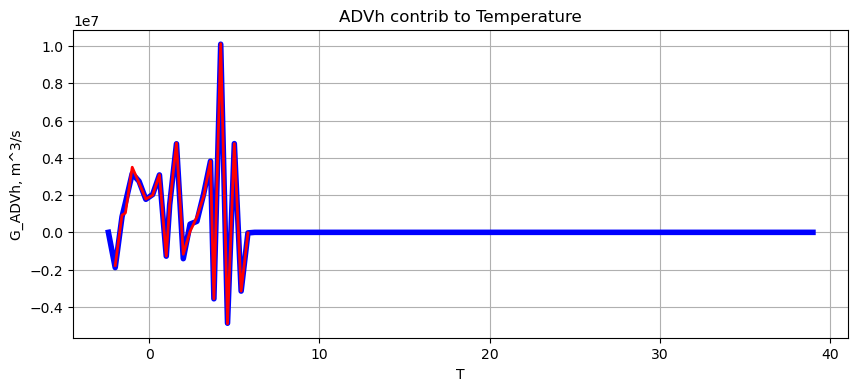

In [32]:
fig = plt.figure()

# make sure this is just the Barents Sea -- not verified that that is true

ax = plt.subplot(111)

ax.plot(boundsT.flatten()[1:-1],G_advh_online,linewidth=4,c="blue",label="online")
ax.plot(boundsT.flatten()[1:-1],G_off_new_h,linewidth=2,c="red",label="offline")
ax.set_ylabel("G_ADVh, m^3/s")
ax.set_xlabel("T")
ax.grid()
plt.title("ADVh contrib to Temperature")

## Create the M term from the gates

We need to find the previous notebook where I marked the gates. Not sure what I called it.

try_again_BarentsSwhole.ipynb

In [33]:
Tbin,Sbin = np.meshgrid(binsTH_centers,binsSLT_centers)

In [34]:
# we want to bin theta and salt into the T and S bins
binned_theta = bin_array(THETA,binsTH_centers)
binned_theta = binned_theta.astype(float)
binned_theta[binned_theta == nT] = np.nan     # because the binning is setting nan to last value
binned_salinity = bin_array(SALT,binsSLT_centers)
binned_salinity = binned_salinity.astype(float)
binned_salinity[binned_salinity == nS] = np.nan

In [35]:
## I think the best way to do this is with the ADV_TH term

In [36]:
# do for the BSO
THETA_face = np.zeros_like(THETA)

# ---- U-faces (collocated with UVEL[j, i]): average in i-direction ----
for j, i in zip(y_bsoh, x_bsoh):
    if i > 0:
        # face between (j, i-1) and (j, i)
        THETA_face[:, j, i] = 0.5 * (THETA[:, j, i] + THETA[:, j, i-1])

# ---- V-faces (collocated with VVEL[j, i]): average in j-direction ----
for j, i in zip(y_bsov, x_bsov):
    if j > 0:
        # face between (j-1, i) and (j, i)
        THETA_face[:, j-1, i] = 0.5 * (THETA[:, j, i] + THETA[:, j-1, i])
THETA_face[THETA_face==0] = np.nan

y_bso_all = np.array([]).astype(int)
x_bso_all = np.array([]).astype(int)

In [43]:

# --- reshape to 3D ---
ADVx_TH = ADVx_TH.reshape((nz, ny, nx))   # advective heat flux on x-faces
ADVy_TH = ADVy_TH.reshape((nz, ny, nx))   # advective heat flux on y-faces
THETA   = THETA.reshape((nz, ny, nx))     # cell-centered temperature

# ------------------------------------------------------------------
# 1. Build theta at faces
# ------------------------------------------------------------------

# x-faces: between (i-1, i) along x
theta_x = np.zeros_like(ADVx_TH)
theta_x[:, :, 1:] = 0.5 * (THETA[:, :, 1:] + THETA[:, :, :-1])
theta_x[:, :, 0]  = theta_x[:, :, 1]      # simple fill for western boundary

# y-faces: between (j-1, j) along y
theta_y = np.zeros_like(ADVy_TH)
theta_y[:, 1:, :] = 0.5 * (THETA[:, 1:, :] + THETA[:, :-1, :])
theta_y[:, 0, :]  = theta_y[:, 1, :]      # simple fill for southern boundary

# ------------------------------------------------------------------
# 2. Convert heat flux (degC·m^3/s) -> volume flux (m^3/s)
#    q_vol = q_heat / theta_face
# ------------------------------------------------------------------

eps = 1e-6  # to avoid divide-by-zero in very cold cells

ADVx_vol = np.zeros_like(ADVx_TH)
mask_x   = np.isfinite(theta_x) & (np.abs(theta_x) > eps)
ADVx_vol[mask_x] = ADVx_TH[mask_x] #/ theta_x[mask_x]

ADVy_vol = np.zeros_like(ADVy_TH)
mask_y   = np.isfinite(theta_y) & (np.abs(theta_y) > eps)
ADVy_vol[mask_y] = ADVy_TH[mask_y] #/ theta_y[mask_y]

# bolus
ADVx_vol = np.zeros_like(ADVx_TH)
mask_x   = np.isfinite(theta_x) & (np.abs(theta_x) > eps)
ADVx_vol[mask_x] = (ADVx_TH[mask_x] + lADBx_TH[mask_x]) #/ theta_x[mask_x]

ADVy_vol = np.zeros_like(ADVy_TH)
mask_y   = np.isfinite(theta_y) & (np.abs(theta_y) > eps)
ADVy_vol[mask_y] = (ADVy_TH[mask_y] + lADBy_TH[mask_y]) #/ theta_y[mask_y]

# ------------------------------------------------------------------
# 3. Build gateway transports using volume fluxes at the faces
#    Sign convention: comments assume "positive into basin"
# ------------------------------------------------------------------

# ADVx_vol = ADVx_TH
# ADVy_vol = ADVy_TH

# ---- BSO ----
ADV_west = np.zeros((nz, ny, nx))
y_bso_all = np.array([], dtype=int)
x_bso_all = np.array([], dtype=int)

# horizontal faces (u-faces)
for j, i in zip(y_bsoh, x_bsoh):
    # flux through x-face at (j,i) mapped into cell (j,i)
    ADV_west[:, j, i] += ADVx_vol[:, j, i]    # + into basin
    y_bso_all = np.append(y_bso_all, j)
    x_bso_all = np.append(x_bso_all, i)

# vertical faces (v-faces)
for j, i in zip(y_bsov, x_bsov):
    # flux through y-face at (j,i) mapped into cell (j-1,i)
    ADV_west[:, j-1, i] -= ADVy_vol[:, j, i]  # sign chosen so + into basin
    y_bso_all = np.append(y_bso_all, j-1)
    x_bso_all = np.append(x_bso_all, i)

# ---- FJNZ ----
ADV_FJNZ = np.zeros((nz, ny, nx))
y_fjnz_all = np.array([], dtype=int)
x_fjnz_all = np.array([], dtype=int)

for j, i in zip(y_fjnzv, x_fjnzv):
    # x-face at (j,i) mapped into (j, i-1), + into basin
    ADV_FJNZ[:, j, i-1] -= ADVx_vol[:, j, i]
    y_fjnz_all = np.append(y_fjnz_all, j)
    x_fjnz_all = np.append(x_fjnz_all, i-1)

# ---- SPFJ (NZ exit) ----
ADV_SPFJ = np.zeros((nz, ny, nx))
y_spfj_all = np.array([], dtype=int)
x_spfj_all = np.array([], dtype=int)

# ORIGINAL
# for j, i in zip(y_spfjh, x_spfjh):
#     ADV_SPFJ[:, j, i-1] -= ADVx_vol[:, j, i]   # + into basin
#     y_spfj_all = np.append(y_spfj_all, j)
#     x_spfj_all = np.append(x_spfj_all, i-1)

# # y-faces
# for j, i in zip(y_spfjv, x_spfjv):
#     ADV_SPFJ[:, j-1, i] -= ADVy_vol[:, j, i]   # + into basin
#     y_spfj_all = np.append(y_spfj_all, j-1)
#     x_spfj_all = np.append(x_spfj_all, i)

# # CHANGED
for j,i in zip(y_spfjv2,x_spfjv2):
    ADV_SPFJ[:, j-1, i] -= ADVy_vol[:, j, i]
    y_spfj_all = np.append(y_spfj_all, j-1)
    x_spfj_all = np.append(x_spfj_all, i)

for j,i in zip(y_spfjh2,x_spfjh2):
    ADV_SPFJ[:, j, i-1] -= ADVx_vol[:, j, i]
    y_spfj_all = np.append(y_spfj_all, j)
    x_spfj_all = np.append(x_spfj_all, i-1)
    
for j,i in zip(y_spfjb2,x_spfjb2):
    ADV_SPFJ[:, j, i-1] -= ADVx_vol[:, j, i]
    y_spfj_all = np.append(y_spfj_all, j)
    x_spfj_all = np.append(x_spfj_all, i-1)
    ADV_SPFJ[:, j-1, i] -= ADVy_vol[:, j, i]
    y_spfj_all = np.append(y_spfj_all, j-1)
    x_spfj_all = np.append(x_spfj_all, i)

# ---- NZRU (small Russia gate) ----
ADV_NZRU = np.zeros((nz, ny, nx))
y_nzru_all = np.array([], dtype=int)
x_nzru_all = np.array([], dtype=int)

for j, i in zip(y_nzruv, x_nzruv):
    ADV_NZRU[:, j, i-1] -= ADVx_vol[:, j, i]   # + into basin
    y_nzru_all = np.append(y_nzru_all, j)
    x_nzru_all = np.append(x_nzru_all, i-1)


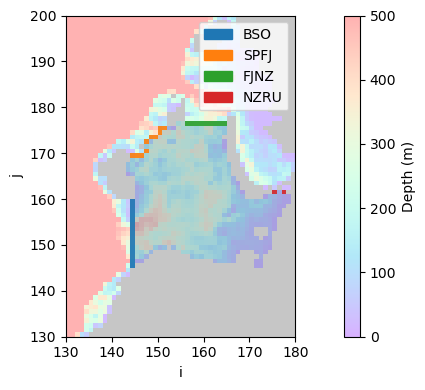

In [44]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

# background: depth
depth_aste = get_aste_tracer(mygrid['Depth'],nfx,nfy)[0]
pc = plt.pcolormesh(depth_aste, cmap="rainbow", vmin=0, vmax=500, alpha=0.3)
plt.colorbar(pc, label="Depth (m)")

# land mask
landmsk = np.zeros((ny, nx))
landmsk[hf1 == 0] = 1
landmsk[hf1 == 1] = np.nan

# your mask
plt.pcolormesh(
    get_aste_tracer(mymsk, nfx, nfy)[0],
    cmap="Blues_r",
    alpha=0.2,
)

# copy gate fields
tspfj = ADV_SPFJ[0].copy()
tbso  = ADV_west[0].copy()
tfjnz = ADV_FJNZ[0].copy()
tnzru = ADV_NZRU[0].copy()

# set zeros to NaN so only gate points show
for arr in (tspfj, tbso, tfjnz, tnzru):
    arr[arr == 0] = np.nan

# ASTE versions, masked
tspfj_aste = np.ma.masked_invalid(get_aste_tracer(tspfj, nfx, nfy)[0])
tbso_aste  = np.ma.masked_invalid(get_aste_tracer(tbso,  nfx, nfy)[0])
tfjnz_aste = np.ma.masked_invalid(get_aste_tracer(tfjnz, nfx, nfy)[0])
tnzru_aste = np.ma.masked_invalid(get_aste_tracer(tnzru, nfx, nfy)[0])

# plot each gate as a single color
plt.pcolormesh(tspfj_aste, cmap=ListedColormap(["tab:orange"]), alpha=0.9)
plt.pcolormesh(tbso_aste,  cmap=ListedColormap(["tab:blue"]),   alpha=0.9)
plt.pcolormesh(tfjnz_aste, cmap=ListedColormap(["tab:green"]),  alpha=0.9)
plt.pcolormesh(tnzru_aste, cmap=ListedColormap(["tab:red"]),    alpha=0.9)

# land mask on top
plt.pcolormesh(
    get_aste_tracer(landmsk, nfx, nfy)[0],
    cmap="Greys",
    alpha=1.0,
    vmin=-2,
    vmax=4,
)

# optional: legend for gate colors
handles = [
    mpatches.Patch(color="tab:blue",   label="BSO"),
    mpatches.Patch(color="tab:orange", label="SPFJ"),
    mpatches.Patch(color="tab:green",  label="FJNZ"),
    mpatches.Patch(color="tab:red",    label="NZRU"),
]
plt.legend(handles=handles, loc="upper right", frameon=True)

plt.xlim(130, 180)
plt.ylim(130, 200)
plt.xlabel("i")
plt.ylabel("j")
plt.gca().set_aspect("equal")

plt.tight_layout()


In [45]:
# plot the four gates at the indices

In [46]:
# print(np.nansum(ADV_west[:,y_bso_all,x_bso_all]))
# print(np.nansum(ADV_westvel[:,y_bso_all,x_bso_all]))
# print(np.nansum(ADVh_BSO))
# # print

In [47]:
ADV_west_flat   = ADV_west.ravel()
ADV_fjnz_flat   = ADV_FJNZ.ravel()
ADV_spfj_flat   = ADV_SPFJ.ravel()
ADV_nzru_flat   = ADV_NZRU.ravel()


# per-bin sums with NaN-propagation
ADVh_BSO = _bincount_sum_with_nan(idx_mid, ADV_west_flat[valid_mid], nTm1)
ADVh_FJNZ = _bincount_sum_with_nan(idx_mid, ADV_fjnz_flat[valid_mid], nTm1)
ADVh_SPFJ = _bincount_sum_with_nan(idx_mid, ADV_spfj_flat[valid_mid], nTm1)
ADVh_NZRU = _bincount_sum_with_nan(idx_mid, ADV_nzru_flat[valid_mid], nTm1)


# edge-based G (m^3/s): divide by edge binwidths
# this is not correct because we want to divide by Face T
G_BSO = ADVh_BSO #/ binwidthT1
G_FJNZ = ADVh_FJNZ #/ binwidthT1
G_SPFJ = ADVh_SPFJ #/ binwidthT1
G_NZRU = ADVh_NZRU #/ binwidthT1

In [48]:
y_bso_all = np.array([]).astype(int)
x_bso_all = np.array([]).astype(int)

In [49]:
# what if we do this with UVEL and VVEL, would that be the same?
DXG3d = np.tile(mygrid['DXG'][np.newaxis,:,:],(nz,1,1))
DYG3d = np.tile(mygrid['DYG'][np.newaxis,:,:],(nz,1,1))
DRF3d = np.tile(mygrid['DRF'][:,np.newaxis,np.newaxis],(1,ny,nx))

# grab the UVEL and VVEL for this timestep
file_name = "budg3d_hflux_set2"
meta_budg3d_hflux_set2 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_hflux_set2["fldList"])
varnames = np.array(["UVELMASS","VVELMASS"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
UVELMASS,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[0])
VVELMASS,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[1])  # m/s
UVELMASS = UVELMASS.reshape(nz,ny,nx)
VVELMASS = VVELMASS.reshape(nz,ny,nx)

# do for the BSO, just put the correct terms in xyz
ADV_westvel = np.zeros((nz,ny,nx))
for j,i, in zip(y_bsoh,x_bsoh):
    ADV_westvel[:,j,i] += UVELMASS[:,j,i] * DYG3d[:,j,i] * DRF3d[:,j,i]       # + into basin
    y_bso_all,x_bso_all = np.append(y_bso_all,j),np.append(x_bso_all,i)
for j,i, in zip(y_bsov,x_bsov):
    ADV_westvel[:,j-1,i] -= VVELMASS[:,j,i] * DXG3d[:,j,i] * DRF3d[:,j,i]
    y_bso_all,x_bso_all = np.append(y_bso_all,j-1),np.append(x_bso_all,i)


# do for FJNZ, again just in xyz space at the gates we add to
y_fjnz_all,x_fjnz_all = np.array([]).astype(int),np.array([]).astype(int)
ADV_FJNZvel = np.zeros((nz,ny,nx))
for j,i, in zip(y_fjnzv,x_fjnzv):
    ADV_FJNZvel[:,j,i-1] -= UVELMASS[:,j,i] * DYG3d[:,j,i] * DRF3d[:,j,i]       # + into basin
    y_fjnz_all,x_fjnz_all = np.append(y_fjnz_all,j),np.append(x_fjnz_all,i-1)


# do for nz exit
ADV_SPFJvel = np.zeros((nz,ny,nx))
for j,i in zip(y_spfjv2,x_spfjv2):
    ADV_SPFJvel[:, j-1, i] -= VVELMASS[:,j,i] * DXG3d[:,j,i] * DRF3d[:,j,i]

for j,i in zip(y_spfjh2,x_spfjh2):
    ADV_SPFJvel[:, j, i-1] -= UVELMASS[:,j,i] * DYG3d[:,j,i] * DRF3d[:,j,i]
    
for j,i in zip(y_spfjb2,x_spfjb2):
    ADV_SPFJvel[:, j, i-1] -= UVELMASS[:,j,i] * DYG3d[:,j,i] * DRF3d[:,j,i]
    ADV_SPFJvel[:, j-1, i] -= VVELMASS[:,j,i] * DXG3d[:,j,i] * DRF3d[:,j,i]


# finally very small russia gate
y_nzru_all,x_nzru_all = np.array([]).astype(int),np.array([]).astype(int)
ADV_NZRUvel = np.zeros((nz,ny,nx))
for j,i, in zip(y_nzruv,x_nzruv):
    ADV_NZRUvel[:,j,i-1] -= UVELMASS[:,j,i] * DYG3d[:,j,i] * DRF3d[:,j,i]      # + into basin
    y_nzru_all,x_nzru_all = np.append(y_nzru_all,j),np.append(x_nzru_all,i-1)  # indices where we write to/budget

In [50]:
# just see if this is the same scale as the other plot first. this should be similar
# we want to sum in axis=1, this is temperature - gets us able to plot this with salinity
ADV_west_flat   = ADV_westvel.ravel()
ADV_fjnz_flat   = ADV_FJNZvel.ravel()
ADV_spfj_flat   = ADV_SPFJvel.ravel()
ADV_nzru_flat   = ADV_NZRUvel.ravel()

# per-bin sums with NaN-propagation
ADVh_BSO = _bincount_sum_with_nan(idx_mid, ADV_west_flat[valid_mid], nTm1)
ADVh_FJNZ = _bincount_sum_with_nan(idx_mid, ADV_fjnz_flat[valid_mid], nTm1)
ADVh_SPFJ = _bincount_sum_with_nan(idx_mid, ADV_spfj_flat[valid_mid], nTm1)
ADVh_NZRU = _bincount_sum_with_nan(idx_mid, ADV_nzru_flat[valid_mid], nTm1)

# edge-based G (m^3/s): divide by edge binwidths
G_BSO_vel = ADVh_BSO
G_FJNZ_vel = ADVh_FJNZ
G_SPFJ_vel = ADVh_SPFJ
G_NZRU_vel = ADVh_NZRU

In [51]:
arr = mygrid['hFacC'].astype(float)  # ensure float so NaNs are allowed

mask_nan = np.isnan(arr)

# Create new array with 1 where original was NaN, and NaN where it wasn't
land_cross = np.where(mask_nan, 1.0, np.nan)

In [52]:
np.nansum(ADV_west[:, y_bso_all, x_bso_all])

16277281.902868867

In [53]:
np.nansum(ADV_westvel[:, y_bso_all, x_bso_all])

1801908.33542223

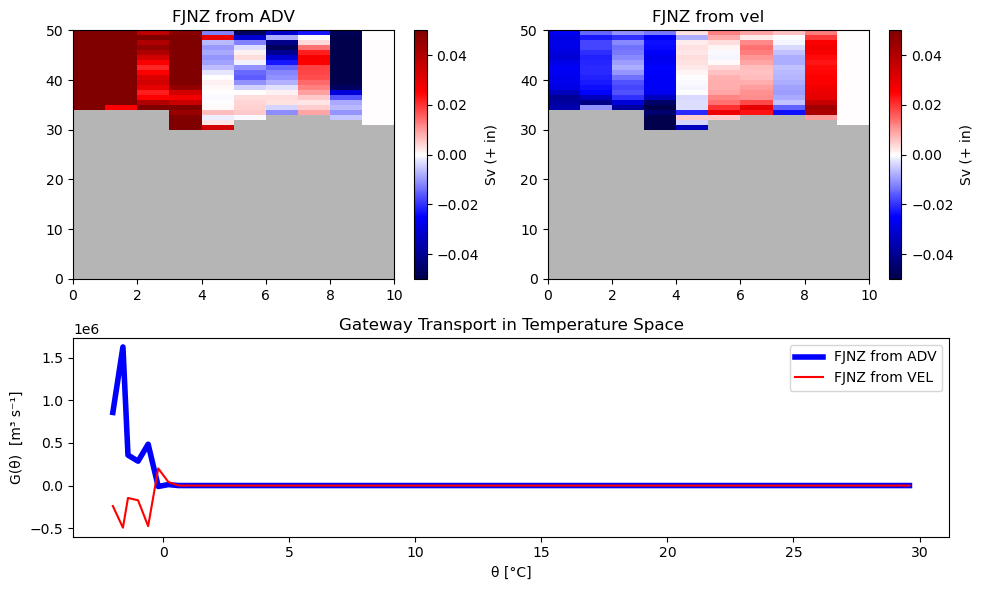

In [54]:

fig = plt.figure(figsize=(10, 6))
gs = fig.add_gridspec(2, 2, height_ratios=[1.0, 0.8])

# --------------------------------------------------
# Top-left: BSO from ADV
# --------------------------------------------------
ax1 = fig.add_subplot(gs[0, 0])
cb = ax1.pcolormesh(
    np.flipud(ADV_FJNZ[:, y_fjnz_all, x_fjnz_all]) * 1e-6,
    cmap='seismic', vmin=-0.05, vmax=0.05
)
ax1.pcolormesh(
    np.flipud(land_cross[:, y_fjnz_all, x_fjnz_all]),
    cmap='Greys', vmin=-1, vmax=4
)
plt.colorbar(cb, ax=ax1, label="Sv (+ in)")
ax1.set_title("FJNZ from ADV")

# --------------------------------------------------
# Top-right: BSO from vel
# --------------------------------------------------
ax2 = fig.add_subplot(gs[0, 1])
cb = ax2.pcolormesh(
    np.flipud(ADV_FJNZvel[:, y_fjnz_all, x_fjnz_all]) * 1e-6,
    cmap='seismic', vmin=-0.05, vmax=0.05
)
ax2.pcolormesh(
    np.flipud(land_cross[:, y_fjnz_all, x_fjnz_all]),
    cmap='Greys', vmin=-1, vmax=4
)
plt.colorbar(cb, ax=ax2, label="Sv (+ in)")
ax2.set_title("FJNZ from vel")

# --------------------------------------------------
# Bottom: gateway transport in θ-space, spanning both columns
# --------------------------------------------------
ax3 = fig.add_subplot(gs[1, :])

G_gates = G_BSO  # make sure these are same shape as boundsT[1:-1]

ax3.plot(
    boundsT.flatten()[1:-1],
    G_FJNZ,
    linewidth=4,
    c="blue",
    label="FJNZ from ADV"
)
ax3.plot(
    boundsT.flatten()[1:-1],
    G_FJNZ_vel,
    linewidth=1.5,
    c="red",
    label="FJNZ from VEL"
)

ax3.set_xlabel("θ [°C]")
ax3.set_ylabel("G(θ)  [m³ s⁻¹]")  # or whatever units you use
ax3.legend(loc="best")
ax3.set_title("Gateway Transport in Temperature Space")

plt.tight_layout()
plt.show()


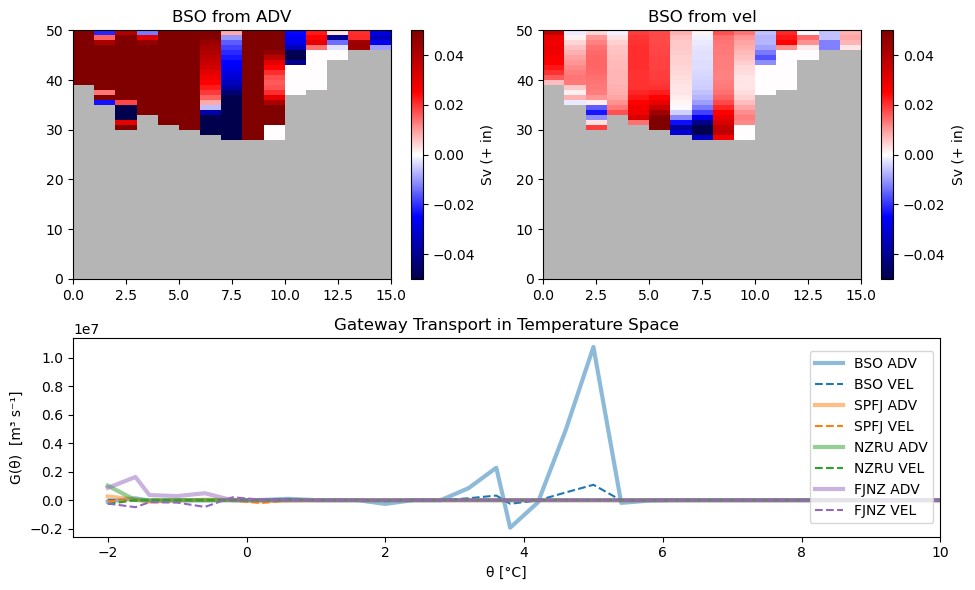

In [55]:
fig = plt.figure(figsize=(10, 6))
gs = fig.add_gridspec(2, 2, height_ratios=[1.0, 0.8])

# --------------------------------------------------
# Top-left: BSO from ADV
# --------------------------------------------------
ax1 = fig.add_subplot(gs[0, 0])
cb = ax1.pcolormesh(
    np.flipud(ADV_west[:, y_bso_all, x_bso_all]) * 1e-6,
    cmap='seismic', vmin=-0.05, vmax=0.05
)
ax1.pcolormesh(
    np.flipud(land_cross[:, y_bso_all, x_bso_all]),
    cmap='Greys', vmin=-1, vmax=4
)
plt.colorbar(cb, ax=ax1, label="Sv (+ in)")
ax1.set_title("BSO from ADV")

# --------------------------------------------------
# Top-right: BSO from vel
# --------------------------------------------------
ax2 = fig.add_subplot(gs[0, 1])
cb = ax2.pcolormesh(
    np.flipud(ADV_westvel[:, y_bso_all, x_bso_all]) * 1e-6,
    cmap='seismic', vmin=-0.05, vmax=0.05
)
ax2.pcolormesh(
    np.flipud(land_cross[:, y_bso_all, x_bso_all]),
    cmap='Greys', vmin=-1, vmax=4
)
plt.colorbar(cb, ax=ax2, label="Sv (+ in)")
ax2.set_title("BSO from vel")

# --------------------------------------------------
# Bottom: gateway transport in θ-space, spanning both columns
# --------------------------------------------------
ax3 = fig.add_subplot(gs[1, :])

G_gates = G_BSO  # make sure these are same shape as boundsT[1:-1]
bounds = boundsT.flatten()[1:-1]

gate_colors = {
    "BSO":  "tab:blue",
    "SPFJ": "tab:orange",
    "NZRU": "tab:green",
    "FJNZ": "tab:purple",
}

# (name, ADV, VEL)
gates = [
    ("BSO",  G_BSO,  G_BSO_vel),
    ("SPFJ", G_SPFJ, G_SPFJ_vel),
    ("NZRU", G_NZRU, G_NZRU_vel),
    ("FJNZ", G_FJNZ, G_FJNZ_vel),
]

for name, G_adv, G_vel in gates:
    color = gate_colors[name]

    # ADV: thick solid
    ax3.plot(
        bounds,
        G_adv,
        linewidth=3,
        color=color,
        label=f"{name} ADV",
        alpha=0.5
    )

    # VEL: thin dashed
    ax3.plot(
        bounds,
        G_vel,
        linewidth=1.5,
        color=color,
        linestyle="--",
        label=f"{name} VEL",
    )

ax3.set_xlim(-2.5,10)

ax3.set_xlabel("θ [°C]")
ax3.set_ylabel("G(θ)  [m³ s⁻¹]")  # or whatever units you use
ax3.legend(loc="right")
ax3.set_title("Gateway Transport in Temperature Space")

plt.tight_layout()
plt.savefig("gateway_example.png",dpi=300)
plt.show()


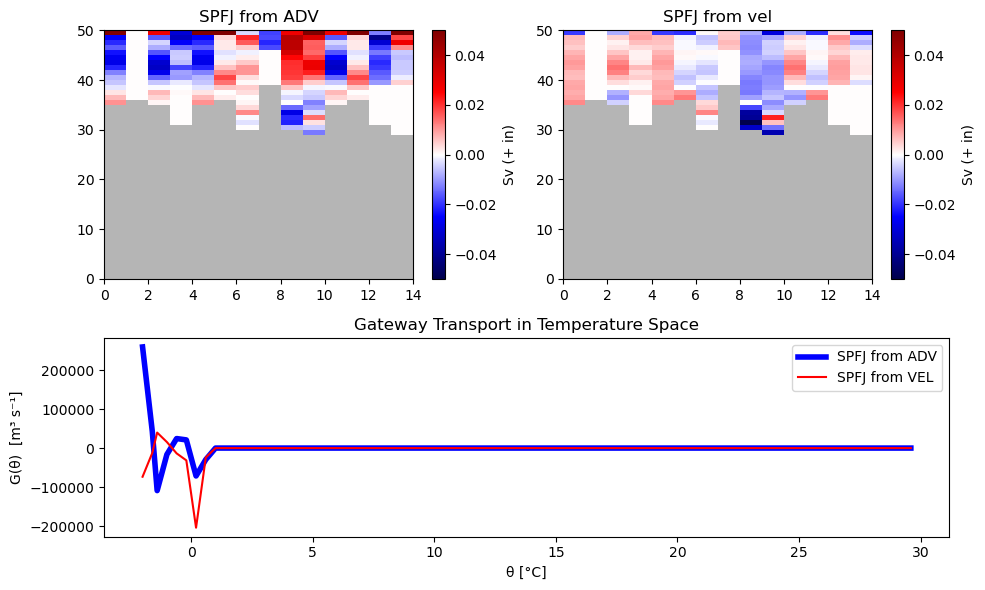

In [56]:
fig = plt.figure(figsize=(10, 6))
gs = fig.add_gridspec(2, 2, height_ratios=[1.0, 0.8])

# --------------------------------------------------
# Top-left: BSO from ADV
# --------------------------------------------------
ax1 = fig.add_subplot(gs[0, 0])
cb = ax1.pcolormesh(
    np.flipud(ADV_SPFJ[:, y_spfj_all, x_spfj_all]) * 1e-6,
    cmap='seismic', vmin=-0.05, vmax=0.05
)
ax1.pcolormesh(
    np.flipud(land_cross[:, y_spfj_all, x_spfj_all]),
    cmap='Greys', vmin=-1, vmax=4
)
plt.colorbar(cb, ax=ax1, label="Sv (+ in)")
ax1.set_title("SPFJ from ADV")

# --------------------------------------------------
# Top-right: BSO from vel
# --------------------------------------------------
ax2 = fig.add_subplot(gs[0, 1])
cb = ax2.pcolormesh(
    np.flipud(ADV_SPFJvel[:, y_spfj_all, x_spfj_all]) * 1e-6,
    cmap='seismic', vmin=-0.05, vmax=0.05
)
ax2.pcolormesh(
    np.flipud(land_cross[:, y_spfj_all, x_spfj_all]),
    cmap='Greys', vmin=-1, vmax=4
)
plt.colorbar(cb, ax=ax2, label="Sv (+ in)")
ax2.set_title("SPFJ from vel")

# --------------------------------------------------
# Bottom: gateway transport in θ-space, spanning both columns
# --------------------------------------------------
ax3 = fig.add_subplot(gs[1, :])

G_gates = G_BSO  # make sure these are same shape as boundsT[1:-1]

ax3.plot(
    boundsT.flatten()[1:-1],
    G_SPFJ,
    linewidth=4,
    c="blue",
    label="SPFJ from ADV"
)
ax3.plot(
    boundsT.flatten()[1:-1],
    G_SPFJ_vel,
    linewidth=1.5,
    c="red",
    label="SPFJ from VEL"
)

ax3.set_xlabel("θ [°C]")
ax3.set_ylabel("G(θ)  [m³ s⁻¹]")  # or whatever units you use
ax3.legend(loc="best")
ax3.set_title("Gateway Transport in Temperature Space")

plt.tight_layout()
plt.show()


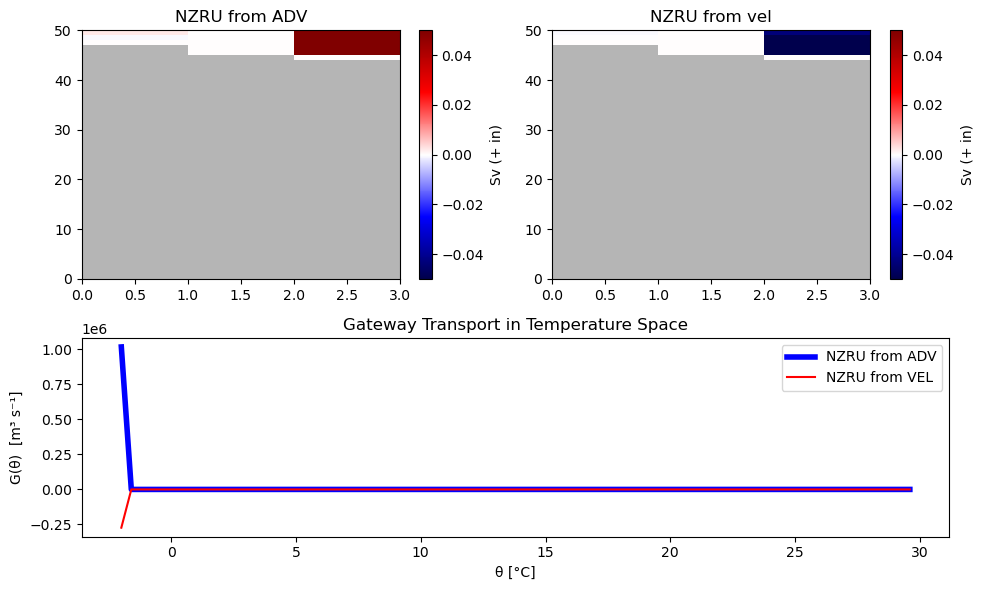

In [57]:
fig = plt.figure(figsize=(10, 6))
gs = fig.add_gridspec(2, 2, height_ratios=[1.0, 0.8])

# --------------------------------------------------
# Top-left: BSO from ADV
# --------------------------------------------------
ax1 = fig.add_subplot(gs[0, 0])
cb = ax1.pcolormesh(
    np.flipud(ADV_NZRU[:, y_nzru_all, x_nzru_all]) * 1e-6,
    cmap='seismic', vmin=-0.05, vmax=0.05
)
ax1.pcolormesh(
    np.flipud(land_cross[:, y_nzru_all, x_nzru_all]),
    cmap='Greys', vmin=-1, vmax=4
)
plt.colorbar(cb, ax=ax1, label="Sv (+ in)")
ax1.set_title("NZRU from ADV")

# --------------------------------------------------
# Top-right: BSO from vel
# --------------------------------------------------
ax2 = fig.add_subplot(gs[0, 1])
cb = ax2.pcolormesh(
    np.flipud(ADV_NZRUvel[:, y_nzru_all, x_nzru_all]) * 1e-6,
    cmap='seismic', vmin=-0.05, vmax=0.05
)
ax2.pcolormesh(
    np.flipud(land_cross[:, y_nzru_all, x_nzru_all]),
    cmap='Greys', vmin=-1, vmax=4
)
plt.colorbar(cb, ax=ax2, label="Sv (+ in)")
ax2.set_title("NZRU from vel")

# --------------------------------------------------
# Bottom: gateway transport in θ-space, spanning both columns
# --------------------------------------------------
ax3 = fig.add_subplot(gs[1, :])


ax3.plot(
    boundsT.flatten()[1:-1],
    G_NZRU,
    linewidth=4,
    c="blue",
    label="NZRU from ADV"
)
ax3.plot(
    boundsT.flatten()[1:-1],
    G_NZRU_vel,
    linewidth=1.5,
    c="red",
    label="NZRU from VEL"
)

ax3.set_xlabel("θ [°C]")
ax3.set_ylabel("G(θ)  [m³ s⁻¹]")  # or whatever units you use
ax3.legend(loc="best")
ax3.set_title("Gateway Transport in Temperature Space")

plt.tight_layout()
plt.show()


In [58]:
name = 'BarentsS'
mysum = np.zeros_like(G_T['BarentsS'][ts]['LTto2TH'])
for key in G_T['BarentsS'][ts].keys():
    if key != 'LTto2TH':
        mysum += G_T[name][ts][key]

ax.plot(boundsT.flatten()[1:-1],mysum,label='sum all online terms')

advonline = G_T['BarentsS'][ts]['LTza2TH'] + G_T['BarentsS'][ts]['LTha2TH']
gates = G_FJNZ_vel + G_SPFJ_vel + G_NZRU_vel + G_BSO_vel # from the velmass terms
# gates = G_FJNZ + G_SPFJ + G_NZRU + G_BSO #

sumwgates = mysum - advonline + gates #+ G_T[name][ts]['LTza2TH']

Text(0, 0.5, 'G(θ)  [m³ s⁻¹]')

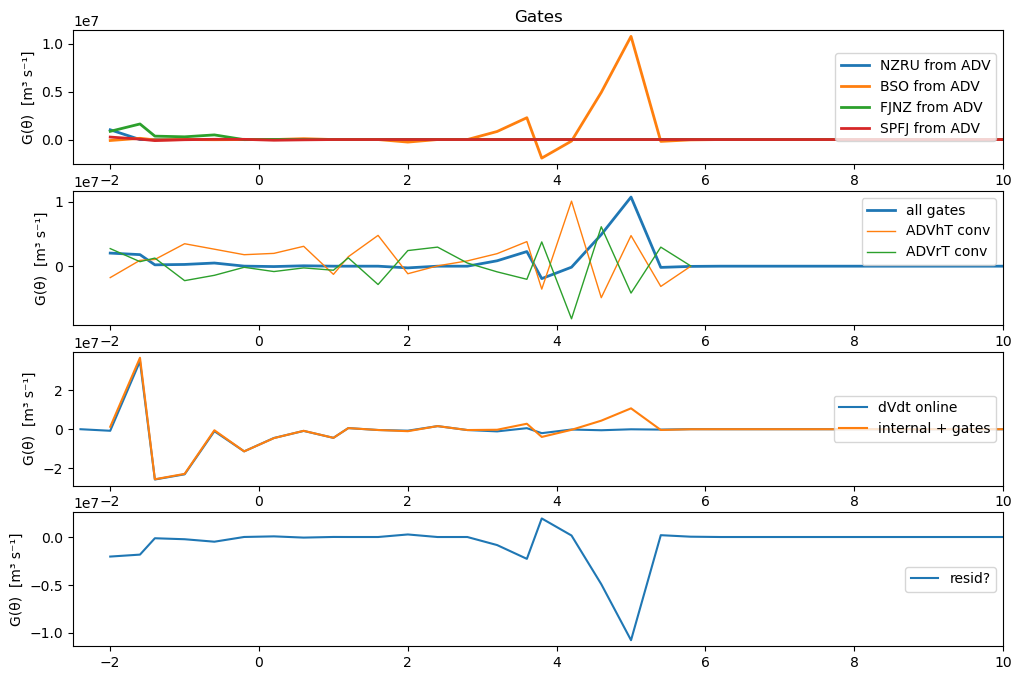

In [59]:
# now show all the gates on one as well as the ADV term from offline

name = 'BarentsS'
fig = plt.figure(figsize = (12,8))

ax = plt.subplot(411)

ax.plot(boundsT.flatten()[1:-1],G_NZRU,linewidth=2,label="NZRU from ADV")
ax.plot(boundsT.flatten()[1:-1],G_BSO,linewidth=2,label="BSO from ADV")
ax.plot(boundsT.flatten()[1:-1],G_FJNZ,linewidth=2,label="FJNZ from ADV")
ax.plot(boundsT.flatten()[1:-1],G_SPFJ,linewidth=2,label="SPFJ from ADV")
ax.set_xlim(-2.5,10)
ax.legend(loc="right")
ax.set_ylabel("G(θ)  [m³ s⁻¹]")
ax.set_title("Gates")

ax = plt.subplot(412)

ax.plot(boundsT.flatten()[1:-1],G_NZRU + G_BSO + G_FJNZ + G_SPFJ,linewidth=2,label="all gates")
ax.plot(boundsT.flatten()[1:-1],G_off_new_h,linewidth=1,label="ADVhT conv")
ax.plot(boundsT.flatten()[1:-1],G_off_new_r,linewidth=1,label="ADVrT conv")

ax.set_xlim(-2.5,10)
ax.legend()
ax.set_ylabel("G(θ)  [m³ s⁻¹]")
# ax.set_title("ADV compared to gates")

ax = plt.subplot(413)
ax.plot(boundsT.flatten()[1:-1], G_T[name][ts]['LTto2TH'],label="dVdt online")
ax.plot(boundsT.flatten()[1:-1], mysum + G_NZRU + G_BSO + G_FJNZ + G_SPFJ,label="internal + gates")
ax.set_xlim(-2.5,10)
ax.legend(loc="right")
ax.set_ylabel("G(θ)  [m³ s⁻¹]")
# ax.set_title("ADV compared to gates")

ax = plt.subplot(414)
ax.plot(boundsT.flatten()[1:-1], (G_T[name][ts]['LTto2TH'] - (mysum + G_NZRU + G_BSO + G_FJNZ + G_SPFJ)),label="resid?")
ax.set_xlim(-2.5,10)
ax.legend(loc="right")
ax.set_ylabel("G(θ)  [m³ s⁻¹]")

In [71]:
print(np.nansum((G_NZRU + G_BSO + G_FJNZ + G_SPFJ)/2))

10512990.032651436


In [72]:
print(np.nansum(ADVhT*mymsk3d))  # but this is in degC.m^3/s

10512990.032651436


In [64]:
ADV_west_flat   = ADV_west.ravel()
ADV_fjnz_flat   = ADV_FJNZ.ravel()
ADV_spfj_flat   = ADV_SPFJ.ravel()
ADV_nzru_flat   = ADV_NZRU.ravel()


# per-bin sums with NaN-propagation
ADVh_BSO = _bincount_sum_with_nan(idx_midS, ADV_west_flat[valid_midS], nSm1)
ADVh_FJNZ = _bincount_sum_with_nan(idx_midS, ADV_fjnz_flat[valid_midS], nSm1)
ADVh_SPFJ = _bincount_sum_with_nan(idx_midS, ADV_spfj_flat[valid_midS], nSm1)
ADVh_NZRU = _bincount_sum_with_nan(idx_midS, ADV_nzru_flat[valid_midS], nSm1)


# edge-based G (m^3/s): divide by edge binwidths
# this is not correct because we want to divide by Face T
G_BSO = ADVh_BSO #/ binwidthT1
G_FJNZ = ADVh_FJNZ #/ binwidthT1
G_SPFJ = ADVh_SPFJ #/ binwidthT1
G_NZRU = ADVh_NZRU #/ binwidthT1

dict_keys(['LTto1SLT', 'LTza1SLT', 'LTha1SLT', 'LaTz1SLT', 'LaTh1SLT', 'LaTs1SLT'])


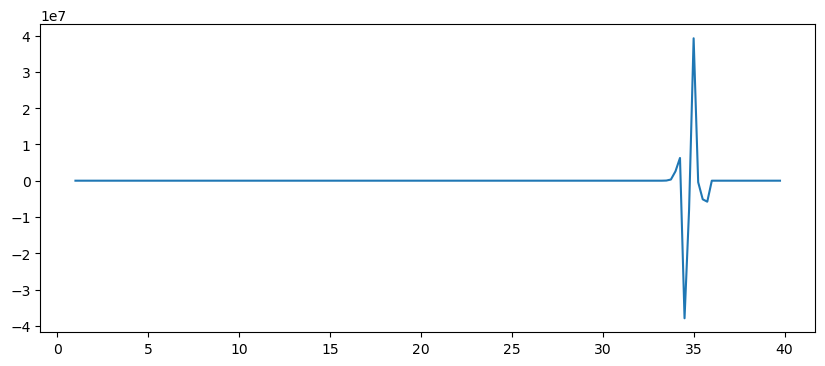

In [65]:
print(G_S[name][ts].keys())

mysum = np.zeros_like(G_S[name][ts]['LTto1SLT'])
for key in G_S[name][ts].keys():
    if key != 'LTto1SLT':
        mysum += G_S[name][ts][key]

plt.plot(boundsS.flatten()[1:-1],mysum,label='sum all online terms')

advonline = G_S[name][ts]['LTza1SLT'] + G_S[name][ts]['LTha1SLT']
gates = G_FJNZ_vel + G_SPFJ_vel + G_NZRU_vel + G_BSO_vel # from the velmass terms
# gates = G_FJNZ + G_SPFJ + G_NZRU + G_BSO #

sumwgates = mysum - advonline + gates #+ G_T[name][ts]['LTza2TH']

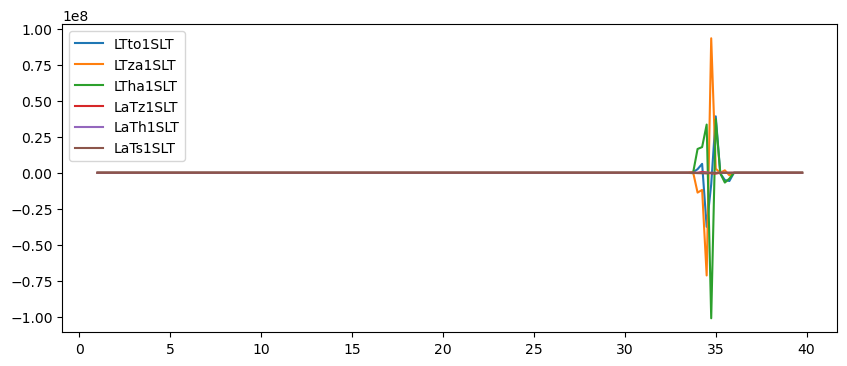

In [66]:
fig = plt.figure()
ax = plt.subplot(111)
for key in G_S[name][ts].keys():
    ax.plot(boundsS.flatten()[1:-1],G_S[name][ts][key],label=key)
ax.legend(loc="best")
# ax.set_xlim(-2.5,10)

Text(0, 0.5, 'G(S)  [m³ s⁻¹]')

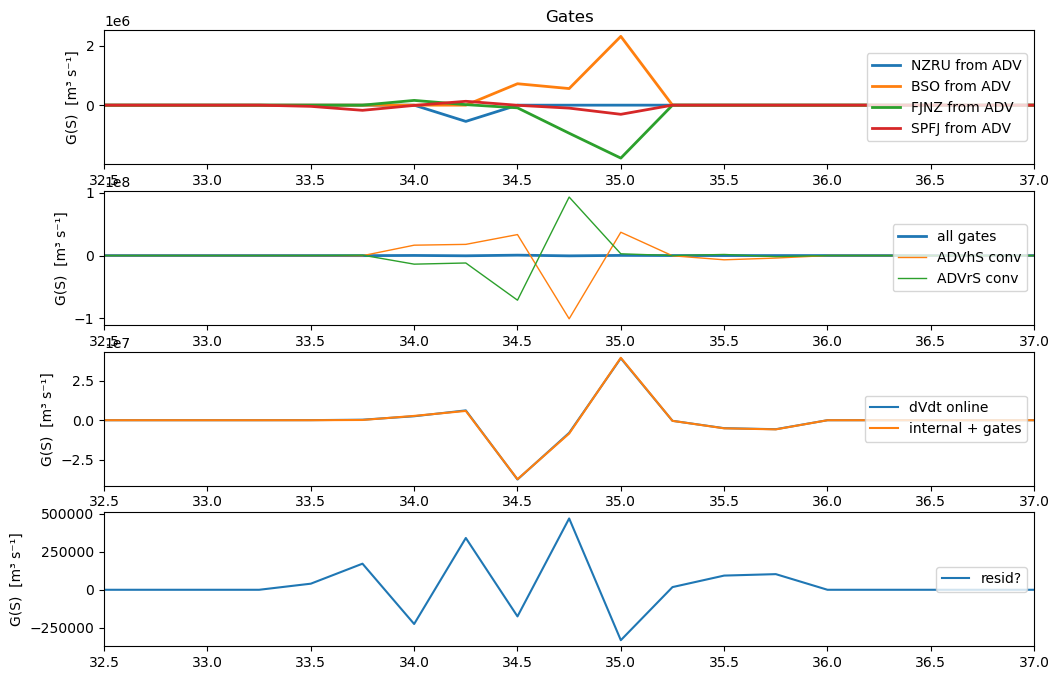

In [67]:
# now show all the gates on one as well as the ADV term from offline

fig = plt.figure(figsize = (12,8))

ax = plt.subplot(411)

ax.plot(boundsS.flatten()[1:-1],G_NZRU,linewidth=2,label="NZRU from ADV")
ax.plot(boundsS.flatten()[1:-1],G_BSO,linewidth=2,label="BSO from ADV")
ax.plot(boundsS.flatten()[1:-1],G_FJNZ,linewidth=2,label="FJNZ from ADV")
ax.plot(boundsS.flatten()[1:-1],G_SPFJ,linewidth=2,label="SPFJ from ADV")
ax.set_xlim(32.5,37)
ax.legend(loc="right")
ax.set_ylabel("G(S)  [m³ s⁻¹]")
ax.set_title("Gates")

ax = plt.subplot(412)

ax.plot(boundsS.flatten()[1:-1],G_NZRU + G_BSO + G_FJNZ + G_SPFJ,linewidth=2,label="all gates")
ax.plot(boundsS.flatten()[1:-1],G_S[name][ts]['LTha1SLT'],linewidth=1,label="ADVhS conv")
ax.plot(boundsS.flatten()[1:-1],G_S[name][ts]['LTza1SLT'],linewidth=1,label="ADVrS conv")


ax.set_xlim(32.5,37)
ax.legend(loc="right")
ax.set_ylabel("G(S)  [m³ s⁻¹]")
# ax.set_title("ADV compared to gates")

ax = plt.subplot(413)
ax.plot(boundsS.flatten()[1:-1], G_S[name][ts]['LTto1SLT'],label="dVdt online")
ax.plot(boundsS.flatten()[1:-1], mysum + G_NZRU + G_BSO + G_FJNZ + G_SPFJ,label="internal + gates")
ax.set_xlim(32.5,37)
ax.legend(loc="right")
ax.set_ylabel("G(S)  [m³ s⁻¹]")
# ax.set_title("ADV compared to gates")

ax = plt.subplot(414)
ax.plot(boundsS.flatten()[1:-1], (G_S[name][ts]['LTto1SLT'] - (mysum + G_NZRU + G_BSO + G_FJNZ + G_SPFJ)),label="resid?")
ax.set_xlim(32.5,37)
ax.legend(loc="right")
ax.set_ylabel("G(S)  [m³ s⁻¹]")

Text(0, 0.5, 'G(S)  [m³ s⁻¹]')

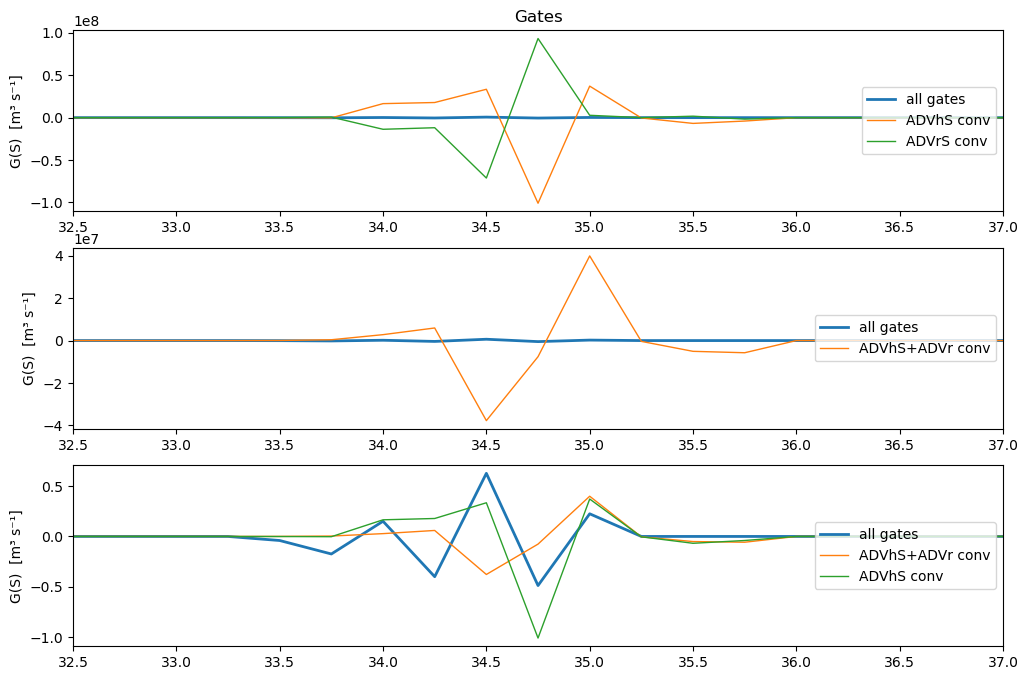

In [68]:
# now show all the gates on one as well as the ADV term from offline

fig = plt.figure(figsize = (12,8))

ax = plt.subplot(311)


ax.plot(boundsS.flatten()[1:-1],G_NZRU + G_BSO + G_FJNZ + G_SPFJ,linewidth=2,label="all gates")
ax.plot(boundsS.flatten()[1:-1],G_S[name][ts]['LTha1SLT'],linewidth=1,label="ADVhS conv")
ax.plot(boundsS.flatten()[1:-1],G_S[name][ts]['LTza1SLT'],linewidth=1,label="ADVrS conv")

ax.set_xlim(32.5,37)
ax.legend(loc="right")
ax.set_ylabel("G(S)  [m³ s⁻¹]")
ax.set_title("Gates")

ax = plt.subplot(312)
ax.plot(boundsS.flatten()[1:-1],G_NZRU + G_BSO + G_FJNZ + G_SPFJ,linewidth=2,label="all gates")
ax.plot(boundsS.flatten()[1:-1],G_S[name][ts]['LTha1SLT'] + G_S[name][ts]['LTza1SLT'],linewidth=1,label="ADVhS+ADVr conv")


ax.set_xlim(32.5,37)
ax.legend(loc="right")
ax.set_ylabel("G(S)  [m³ s⁻¹]")
# ax.set_title("ADV compared to gates")


ax = plt.subplot(313)
ax.plot(boundsS.flatten()[1:-1],(G_NZRU + G_BSO + G_FJNZ + G_SPFJ)/1e6,linewidth=2,label="all gates")
ax.plot(boundsS.flatten()[1:-1],(G_S[name][ts]['LTha1SLT'] + G_S[name][ts]['LTza1SLT'])/1e8,linewidth=1,label="ADVhS+ADVr conv")
ax.plot(boundsS.flatten()[1:-1],(G_S[name][ts]['LTha1SLT'])/1e8,linewidth=1,label="ADVhS conv")


ax.set_xlim(32.5,37)
ax.legend(loc="right")
ax.set_ylabel("G(S)  [m³ s⁻¹]")
# ax.set_title("ADV compared to gates")

In [65]:
print(np.nansum((G_NZRU + G_BSO + G_FJNZ + G_SPFJ)/binwidthT1))

54522869.5622762


In [72]:
print(np.nansum(G_S[name][ts]['LTha1SLT'] + G_S[name][ts]['LTza1SLT']))

-7487475.268180169


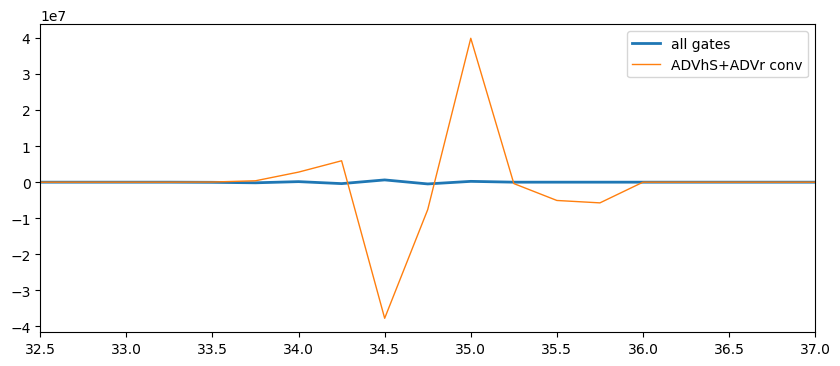

In [69]:
fig = plt.figure()
ax = plt.subplot(111)

ax.plot(boundsS.flatten()[1:-1],G_NZRU + G_BSO + G_FJNZ + G_SPFJ,linewidth=2,label="all gates")
ax.plot(boundsS.flatten()[1:-1],G_S[name][ts]['LTha1SLT'] + G_S[name][ts]['LTza1SLT'],linewidth=1,label="ADVhS+ADVr conv")
ax.set_xlim(32.5,37)
ax.legend()

## try to load the J terms to do this in TS space

In [298]:
setTS_Stend=parsemeta(layers_path + "diags/LAYERS/layers_TSjoint_Stend_set1.0000000003.meta")["fldList"]
setTS_Stend

['LaSs_TS', 'LaSh_TS', 'LaSz_TS', 'LSha_TS', 'LSza_TS', 'LSto_TS']

In [299]:
# DO NOT RUN IF HAS ALREADY BEEN CALCULATED
# JUST FOR SET1 HERE - NOT FOR SET 2
# 287 - should be indexing nt, ns, wetpoints
# T, S, wetpoints
Jx = {}
# set each basin to its own dictionary
Jx[name] = {}
Jx[name]['G_S'] = {}
Jx[name]['G_S']['residS'] = {}

rac = mygrid['RAC']
hf1 = hf1.reshape(ny,nx)

for i in range(len(setTS_Stend)-1, -1, -1):
    t0 = time.localtime()
    # CHECK THIS IS SHAPED CORRECTLY - HOW
    filename = layers_path + "diags/LAYERS/layers_TSjoint_Stend_set1" + "." + tsstr[-1] + ".data"
    tmp = read_float64_skip(filename, LwetC2d*(nS-1)*(nT-1),i)
    print(tmp.shape)
    tmp = np.reshape(tmp,(nT-1,nS-1,LwetC2d))
    print(tmp.shape)

    small = rac2d * hf2d
    tmp = tmp * np.tile(small[np.newaxis,np.newaxis,:], (nT - 1, nS - 1,1)) * ffac

    # if at end of loop
    if i == len(setTS_Stend)-1:
        f = (np.nansum(tmp, axis=2))
        f = np.nansum(f * binwidthT1)

    # double check the names in the listed file
    if i == len(setTS_Stend)-1:
        # do not remove from the residual - this is the total tendency
        residT = tmp
    elif i in {0,1,2,3,4}:
        # LaTs_TS LaTh_TS LaTz_TS LTha_TS LTza_TS (LTBh_TS)
        # surface forcing, hDiff, vDiff, hADV, vADV, hADV bolus
        residT = residT - tmp
    tmp1 = np.nansum(tmp[:,:,iwet_mine],axis=2)   # SUM OVER WET POINTS - should be of shape nS-1, nT-1
    # TEST:
    tmp1 = tmp1.T
    tmp2 = np.nansum(tmp1 * binwidthT1,axis=1)              # SUM OVER S - should be of shape nT-1
    Jx[name][setTS_Stend[i]] = tmp1
    Jx[name]['G_S'][setTS_Stend[i]] = tmp2
    del tmp
    del tmp1
    del tmp2

(499000500,)
(111, 111, 40500)
(499000500,)
(111, 111, 40500)
(499000500,)
(111, 111, 40500)
(499000500,)
(111, 111, 40500)
(499000500,)
(111, 111, 40500)
(499000500,)
(111, 111, 40500)


In [300]:
setTS_Ttend=parsemeta(layers_path + "diags/LAYERS/layers_TSjoint_Ttend_set1.0000000003.meta")["fldList"]


In [301]:
# DO NOT RUN IF HAS ALREADY BEEN CALCULATED
# JUST FOR SET1 HERE - NOT FOR SET 2
# 287 - should be indexing nt, ns, wetpoints
# T, S, wetpoints
Jy = {}
# set each basin to its own dictionary
Jy[name] = {}
Jy[name]['G_T'] = {}
Jy[name]['G_T']['residT'] = {}

rac = mygrid['RAC']
hf1 = hf1.reshape(ny,nx)

for i in range(len(setTS_Ttend)-1, -1, -1):
    t0 = time.localtime()
    # CHECK THIS IS SHAPED CORRECTLY - HOW
    filename = layers_path + "diags/LAYERS/layers_TSjoint_Ttend_set1" + "." + tsstr[-1] + ".data"
    tmp = read_float64_skip(filename, LwetC2d*(nS-1)*(nT-1),i)
    print(tmp.shape)
    tmp = np.reshape(tmp,(nT-1,nS-1,LwetC2d))
    print(tmp.shape)

    small = rac2d * hf2d
    tmp = tmp * np.tile(small[np.newaxis,np.newaxis,:], (nT - 1, nS - 1,1)) * ffac

    # if at end of loop
    if i == len(setTS_Ttend)-1:
        f = (np.nansum(tmp, axis=2))
        f = np.nansum(f * binwidthS1)

    # double check the names in the listed file
    if i == len(setTS_Ttend)-1:
        # do not remove from the residual - this is the total tendency
        residT = tmp
    elif i in {0,1,2,3,4}:
        # LaTs_TS LaTh_TS LaTz_TS LTha_TS LTza_TS (LTBh_TS)
        # surface forcing, hDiff, vDiff, hADV, vADV, hADV bolus
        residT = residT - tmp
    tmp1 = np.nansum(tmp[:,:,iwet_mine],axis=2)   # SUM OVER WET POINTS - should be of shape nS-1, nT-1
    # TEST:
    tmp1 = tmp1.T
    tmp2 = np.nansum(tmp1 * binwidthS1,axis=1)              # SUM OVER S - should be of shape nT-1
    Jy[name][setTS_Ttend[i]] = tmp1
    Jy[name]['G_T'][setTS_Ttend[i]] = tmp2
    del tmp
    del tmp1
    del tmp2


myresid = np.nansum(residT[:,:,iwet_mine],axis=2)    # SUM OVER WET POINTS - should be of shape nS-1, nT-1
# TEST:
myresid = myresid.T
Jy[name]["residT"] = myresid
Jy[name]["G_T"]["residT"] = np.nansum(Jy[name]["residT"] * binwidthS1,axis=1)   #SUM OVER S - should be of shape nT-1

# set units and labels
Jy["unit"] = "m/s/psu"
Jy["G_T"] = {}
Jy["G_T"]["unit"] = "m/s"
Jy["G_T"]["descr"] = "G_T=integral(Jy,dS)"

(499000500,)
(111, 111, 40500)
(499000500,)
(111, 111, 40500)
(499000500,)
(111, 111, 40500)
(499000500,)
(111, 111, 40500)
(499000500,)
(111, 111, 40500)
(499000500,)
(111, 111, 40500)


In [324]:
def calc_UV_conv_TS(JtermsS, JtermsT, binwidthS1tile, binwidthT1tile, bc="zero"):
    """
    Compute convergence in TS space with same-shape output.
    JtermsS, JtermsT: arrays shaped (nterms, nS, nT)
    binwidthS1tile, binwidthT1tile: broadcastable to (nS, nT)
    bc: "zero" (default) or "periodic"
    """
    conv = np.zeros_like(JtermsS)
    convUa = np.zeros_like(JtermsS)
    convVa = np.zeros_like(JtermsS)
    nterms = JtermsS.shape[0]

    for i in range(nterms):
        JS = JtermsS[i]  # flux along S-axis   Sv/degC
        JT = JtermsT[i]  # flux along T-axis   Sv/PSU

        # same-shape arrays
        convU = np.zeros_like(JS)
        convV = np.zeros_like(JT)

        # interior differences (lose one neighbor, keep shape by assigning into interior)
        convU[:, :-1] = JS[:, :-1] - JS[:, 1:]      # d/dS of S-flux
        convV[:-1, :] = JT[:-1, :] - JT[1:, :]      # d/dT of T-flux

        convU[:, -1] = 0.0
        convV[-1, :] = 0.0

        # normalize by bin widths (broadcasts)
        convU = convU / binwidthS1tile       # m/s/degC/PSU
        convV = convV / binwidthT1tile       # m/s/PSU/degC

        # total convergence for this term
        conv[i] = convU + convV
        convUa[i] = convU
        convVa[i] = convV

    return conv,convUa,convVa

# TSconv,convU,convV = calc_UV_conv_TS(JtermsS, JtermsT, binwidthS1tile, binwidthT1tile)

In [325]:
JtermsS = np.zeros((6,nT-1,nS-1))
JtermsT = np.zeros((6,nT-1,nS-1))

i = 0
for key in Jy[name].keys():
    if key != "G_T":
        if key != "residT":
            JtermsS[i] = Jy[name][key]  # Sv/degC
            i += 1

i = 0
for key in Jx[name].keys():
    if key != "G_S":
        JtermsT[i] = Jx[name][key]      # Sv/PSU
        i += 1

In [326]:
print(Jy[name].keys())
print(Jx[name].keys())

dict_keys(['G_T', 'LTto_TS', 'LTza_TS', 'LTha_TS', 'LaTz_TS', 'LaTh_TS', 'LaTs_TS', 'residT'])
dict_keys(['G_S', 'LSto_TS', 'LSza_TS', 'LSha_TS', 'LaSz_TS', 'LaSh_TS', 'LaSs_TS'])


In [327]:
binwidthT1tile = np.tile(binwidthT1[np.newaxis,:],(nT-1,1))
binwidthS1tile = np.tile(binwidthS1[:,np.newaxis],(1,nS-1))
TSconv,convU,convV = calc_UV_conv_TS(JtermsS, JtermsT, binwidthS1tile, binwidthT1tile)

In [328]:
TSconv.shape  # total, zadv, hadv, zdiff, hdiff, surf

(6, 111, 111)

Text(0.5, 1.0, 'sum of terms')

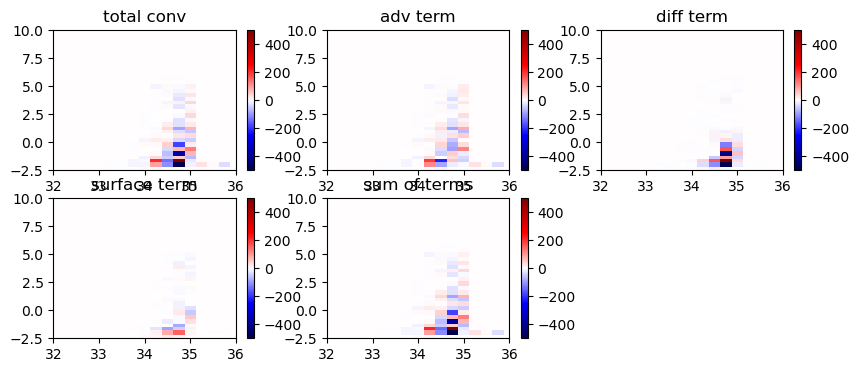

In [334]:
fig = plt.figure()

ax = plt.subplot(231)
cb = ax.pcolormesh(Sbin,Tbin,TSconv[0],cmap='seismic',vmin=-500,vmax=500)
ax.set_xlim(32,36)
ax.set_ylim(-2.5,10)
plt.colorbar(cb)
ax.set_title("total conv")

ax = plt.subplot(232)
cb = ax.pcolormesh(Sbin,Tbin,np.nansum(TSconv[1:3],axis=0),cmap='seismic',vmin=-500,vmax=500)
ax.set_xlim(32,36)
ax.set_ylim(-2.5,10)
plt.colorbar(cb)
ax.set_title("adv term")

ax = plt.subplot(233)
cb = ax.pcolormesh(Sbin,Tbin,np.nansum(TSconv[3:5],axis=0),cmap='seismic',vmin=-500,vmax=500)
ax.set_xlim(32,36)
ax.set_ylim(-2.5,10)
plt.colorbar(cb)
ax.set_title("diff term")

ax = plt.subplot(234)
cb = ax.pcolormesh(Sbin,Tbin,TSconv[5],cmap='seismic',vmin=-500,vmax=500)
ax.set_xlim(32,36)
ax.set_ylim(-2.5,10)
plt.colorbar(cb)
ax.set_title("surface term")

ax = plt.subplot(235)
cb = ax.pcolormesh(Sbin,Tbin,np.nansum(TSconv[1:],axis=0),cmap='seismic',vmin=-500,vmax=500)
ax.set_xlim(32,36)
ax.set_ylim(-2.5,10)
plt.colorbar(cb)
ax.set_title("sum of terms")

In [361]:
J_BSO = np.zeros((nS-1, nT-1), dtype=float)

for i, j in zip(y_bso_all, x_bso_all):
    for k in range(nz):
        tbin = int(binned_theta[k, i, j])
        sbin = int(binned_salinity[k, i, j])

        # skip out-of-range or non-finite points
        if not (0 <= tbin < nT-1 and 0 <= sbin < nS-1):
            continue
        v = ADV_west[k, i, j]
        if not np.isfinite(v):
            continue

        J_BSO[sbin, tbin] += v  # accumulate transport (m^3/s)

# Convert to density if desired:
J_BSO = (J_BSO * 1e-6) / (binwidthS1[:, None] * binwidthT1[None, :])  # Sv/(PSU·°C)

# get the TS diagram for this
J_FJNZ = np.zeros((nS-1,nT-1))
for i,j in zip(y_fjnz_all, x_fjnz_all):

    # loop through the z values and see if we can plot
    for k in range(nz):                 # stop at second to last level for 
        iTpt = int(binned_theta[k,i,j])             # these are already binned by the bins edges
        iSpt = int(binned_salinity[k,i,j])

        # save the J terms for here for the single point   
        J_FJNZhere = (ADV_FJNZ[k,i,j]) / binwidthT1[iTpt] / binwidthS1[iSpt] * 1e-6             # Sv/PSU/degC

        J_FJNZ[iSpt,iTpt] += J_FJNZhere

J_FJNZ = (J_FJNZ * 1e-6) / (binwidthS1[:, None] * binwidthT1[None, :])  # Sv/(PSU·°C)

# get the TS diagram for this
J_NZRU = np.zeros((nS-1,nT-1))
for i,j in zip(y_nzru_all, x_nzru_all):

    # loop through the z values and see if we can plot
    for k in range(nz):                 # stop at second to last level for 
        iTpt = int(binned_theta[k,i,j])             # these are already binned by the bins edges
        iSpt = int(binned_salinity[k,i,j])

        # save the J terms for here for the single point   
        J_NZRUhere = (ADV_NZRU[k,i,j]) / binwidthT1[iTpt] / binwidthS1[iSpt] * 1e-6             # Sv/PSU/degC

        J_NZRU[iSpt,iTpt] += J_NZRUhere

J_NZRU = (J_NZRU * 1e-6) / (binwidthS1[:, None] * binwidthT1[None, :])  # Sv/(PSU·°C)

# get the TS diagram for this
J_SPFJ = np.zeros((nS-1,nT-1))
for i,j in zip(y_spfj_all, x_spfj_all):

    # loop through the z values and see if we can plot
    for k in range(nz):                 # stop at second to last level for 
        iTpt = int(binned_theta[k,i,j])             # these are already binned by the bins edges
        iSpt = int(binned_salinity[k,i,j])

        # save the J terms for here for the single point   
        J_SPFJhere = (ADV_SPFJ[k,i,j]) / binwidthT1[iTpt] / binwidthS1[iSpt] * 1e-6             # Sv/PSU/degC

        J_SPFJ[iSpt,iTpt] += J_SPFJhere

J_SPFJ = (J_SPFJ * 1e-6) / (binwidthS1[:, None] * binwidthT1[None, :])  # Sv/(PSU·°C)


Text(0.5, 1.0, 'sum of terms')

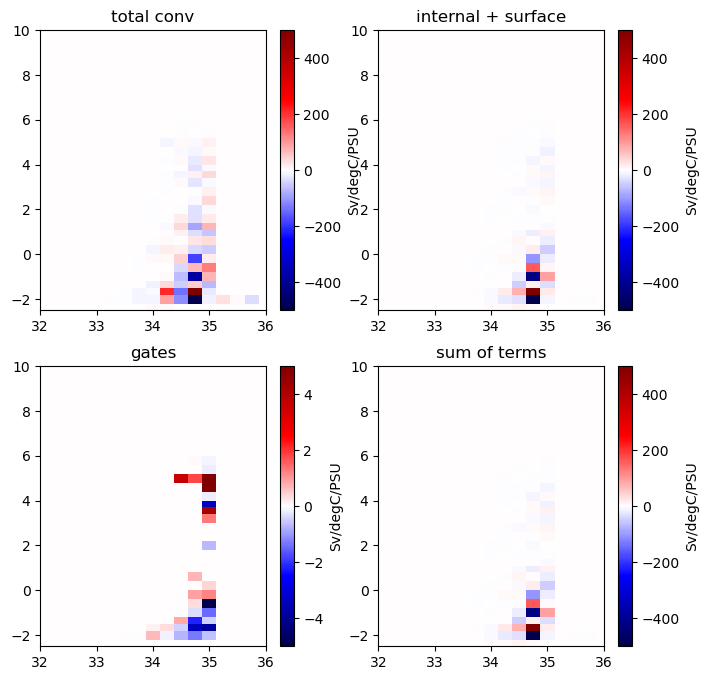

In [365]:
fig = plt.figure(figsize = (8,8))

ax = plt.subplot(221)
cb = ax.pcolormesh(Sbin,Tbin,TSconv[0],cmap='seismic',vmin=-500,vmax=500)
ax.set_xlim(32,36)
ax.set_ylim(-2.5,10)
plt.colorbar(cb,label="Sv/degC/PSU")
ax.set_title("total conv")

ax = plt.subplot(222)
cb = ax.pcolormesh(Sbin,Tbin,np.nansum(TSconv[3:],axis=0),cmap='seismic',vmin=-500,vmax=500)
ax.set_xlim(32,36)
ax.set_ylim(-2.5,10)
plt.colorbar(cb,label="Sv/degC/PSU")
ax.set_title("internal + surface")

ax = plt.subplot(223)
cb = ax.pcolormesh(Sbin,Tbin,J_BSO+J_FJNZ+J_NZRU+J_SPFJ,cmap='seismic',vmin=-5,vmax=5)
ax.set_xlim(32,36)
ax.set_ylim(-2.5,10)
plt.colorbar(cb,label="Sv/degC/PSU")
ax.set_title("gates")

ax = plt.subplot(224)
cb = ax.pcolormesh(Sbin,Tbin,np.nansum(TSconv[3:],axis=0) + J_BSO+J_FJNZ+J_NZRU+J_SPFJ,cmap='seismic',vmin=-500,vmax=500)
ax.set_xlim(32,36)
ax.set_ylim(-2.5,10)
plt.colorbar(cb,label="Sv/degC/PSU")
ax.set_title("sum of terms")

## do a tester plot as we add the gates above to the existing plot

Text(0.5, 1.0, 'Gates from Vel terms')

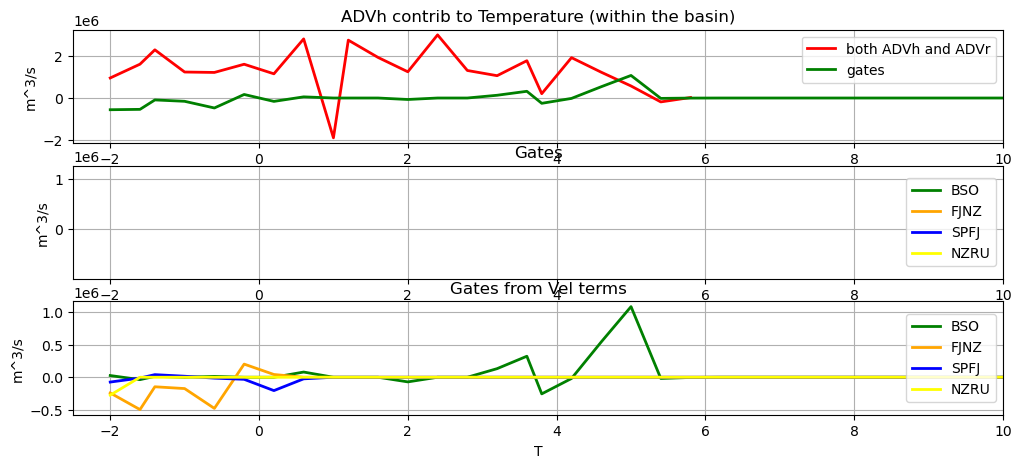

In [369]:
fig = plt.figure(figsize = (12,5))

ax = plt.subplot(311)

# ax.plot(boundsT.flatten()[1:-1],G_advh_online,linewidth=4,c="blue",label="online")
ax.plot(boundsT.flatten()[1:-1],G_off_new_h + G_off_new_r,linewidth=2,c="red",label="both ADVh and ADVr")
ax.plot(boundsT.flatten()[1:-1],G_BSO_vel  + G_FJNZ_vel + G_SPFJ_vel + G_NZRU_vel,linewidth=2,c="green",label="gates")
ax.set_ylabel("m^3/s")
ax.set_xlabel("T")
ax.legend(loc="best")
ax.set_xlim(-2.5,10)
ax.grid()
plt.title("ADVh contrib to Temperature (within the basin)")


ax = plt.subplot(312)
ax.plot(boundsT.flatten()[1:-1],G_BSO,linewidth=2,c="green",label="BSO")
ax.plot(boundsT.flatten()[1:-1],G_FJNZ,linewidth=2,c="orange",label="FJNZ")
ax.plot(boundsT.flatten()[1:-1],G_SPFJ,linewidth=2,c="blue",label="SPFJ")
ax.plot(boundsT.flatten()[1:-1],G_NZRU,linewidth=2,c="yellow",label="NZRU")
ax.set_ylabel("m^3/s")
ax.set_xlabel("T")
ax.set_xlim(-2.5,10)
ax.legend(loc="right")
ax.grid()
plt.title("Gates")

ax = plt.subplot(313)
ax.plot(boundsT.flatten()[1:-1],G_BSO_vel,linewidth=2,c="green",label="BSO")
ax.plot(boundsT.flatten()[1:-1],G_FJNZ_vel,linewidth=2,c="orange",label="FJNZ")
ax.plot(boundsT.flatten()[1:-1],G_SPFJ_vel,linewidth=2,c="blue",label="SPFJ")
ax.plot(boundsT.flatten()[1:-1],G_NZRU_vel,linewidth=2,c="yellow",label="NZRU")
ax.set_ylabel("m^3/s")
ax.set_xlabel("T")
ax.set_xlim(-2.5,10)
ax.legend(loc="right")
ax.grid()
plt.title("Gates from Vel terms")

In [295]:
# we cannot purely divide by binwidthT1 because this will give positive values that should be negative (outflow)
np.nansum(G_off_new_h)# + G_off_new_r)

26885526.425694123

In [296]:
np.nansum(G_advh_online + G_advr_online)

28063461.494018495

In [367]:
G_off_new_r

array([              nan,  2736493.89797704,   702990.4493017 ,
        1260045.93874068, -2250978.50916979, -1421323.92916801,
        -172158.25067722,  -835848.68550748,  -267324.89433364,
        -629784.39968221,  1296021.52638368, -2853162.69847067,
        2430502.35174682,  2967791.34945973,   492683.04770626,
        -881648.35292865, -2039826.86648055,  3776402.73597182,
       -8190367.6281877 ,  6136430.9170563 , -4185022.57493406,
        2965893.11025866,    53651.71330032,               nan,
                     nan,               nan,               nan,
                     nan,               nan,               nan,
                     nan,               nan,               nan,
                     nan,               nan,               nan,
                     nan,               nan,               nan,
                     nan,               nan,               nan,
                     nan,               nan,               nan,
                     nan,               

In [297]:
np.nansum(G_BSO + G_FJNZ + G_SPFJ + G_NZRU)  # this shows that the contribution from the gates from ADV is at least similar

-49633.62524224187

## Try to load/create the J terms with layers

## Let's check this against dVdt (can copy existing code over using ETAN)

In [56]:
dt = 8

In [57]:
file_name = 'budg2d_snap_set1'
meta_budg2d_snap_set1 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")

# try to read this with rec
fldlist = np.array(meta_budg2d_snap_set1['fldList'])
varnames = np.array(['ETAN','PHIBOT','SIheff','SIhsnow'])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])

ETAN = np.full((len(tsstr),ny,nx),np.nan)
PHIBOT = np.full((len(tsstr),ny,nx),np.nan)
SIheff = np.full((len(tsstr),ny,nx),np.nan)
SIhsnow = np.full((len(tsstr),ny,nx),np.nan)

for i in range(len(tsstr)):
    thisETAN,its,meta = rdmds(os.path.join(dirdiags, file_name),int(tsstr[i]),returnmeta=True,rec=recs[0])
    thisETAN = thisETAN.reshape(ny,nx)
    ETAN[i] = thisETAN

    thisPHIBOT,its,meta = rdmds(os.path.join(dirdiags, file_name),int(tsstr[i]),returnmeta=True,rec=recs[1])
    thisPHIBOT = thisPHIBOT.reshape(ny,nx)
    PHIBOT[i] = thisPHIBOT

    thisSIheff,its,meta = rdmds(os.path.join(dirdiags, file_name),int(tsstr[i]),returnmeta=True,rec=recs[2])
    thisSIheff = thisSIheff.reshape(ny,nx)
    SIheff[i] = thisSIheff

    thisSIhsnow,its,meta = rdmds(os.path.join(dirdiags, file_name),int(tsstr[i]),returnmeta=True,rec=recs[3])
    thisSIhsnow = thisSIhsnow.reshape(ny,nx)
    SIhsnow[i] = thisSIhsnow
    
def volume_hist_theta(THETA, ETAN_t,mymsk3d):
    """Return V(θ) [m³ per bin] including real-FW ETAN effect."""
    THETA = THETA.reshape(nz, ny, nx)

    # static volume
    DRF3     = mk3D_mod(mygrid['DRF'], hfC) * hfC    # m
    cell_vol = DRF3 * RAC3                            # m³
    cell_vol = cell_vol * mymsk3d                     # mask

    # add surface-height volume change (RFWF active)
    cell_vol[0, :, :] += ETAN_t * RAC                # m * m² = m³

    # flatten and bin
    theta_flat = THETA.ravel()
    vol_flat   = cell_vol.ravel()

    valid = (vol_flat > 0) & np.isfinite(theta_flat)
    theta_flat = theta_flat[valid]
    vol_flat   = vol_flat[valid]

    # build θ-edges from centers
    nT = len(binsTH_centers)
    dT = np.diff(binsTH_centers)
    edges = np.empty(nT + 1)
    edges[1:-1] = binsTH_centers[:-1] + 0.5 * dT
    edges[0]    = binsTH_centers[0]  - 0.5 * dT[0]
    edges[-1]   = binsTH_centers[-1] + 0.5 * dT[-1]

    bin_idx = np.digitize(theta_flat, edges) - 1
    bin_idx = np.clip(bin_idx, 0, nT - 1)

    V = np.bincount(bin_idx, weights=vol_flat, minlength=nT-1)  # m³/bin
    return V


In [58]:
DRF3     = mk3D_mod(mygrid['DRF'], hfC) * hfC    # m
cell_vol = DRF3 * RAC3                            # m³
cell_vol = cell_vol * mymsk3d                     # mask

tmp1 = mk3D_mod(mygrid['DRF'],hfC) * hfC           # m^2
tmp2 = tmp1/mk3D_mod(DD,tmp1)

V1 = cell_vol + (tmp2 * np.tile(ETAN[0,:,:],(nz,1,1)) * RAC3 * mymsk3d)
V2 = cell_vol + (tmp2 * np.tile(ETAN[1,:,:],(nz,1,1)) * RAC3 * mymsk3d)


theta_flat = THETA1.ravel()
vals = V1.ravel().astype(float)
bin_idx_mid = np.digitize(theta_flat, binmidT, right=False) - 1
valid_mid   = (bin_idx_mid >= 0) & (bin_idx_mid < nTm1) & np.isfinite(theta_flat)
V1b = _bincount_sum_with_nan(idx_mid, vals[valid_mid], nTm1)

theta_flat = THETA2.ravel()
vals = V2.ravel().astype(float)
bin_idx_mid = np.digitize(theta_flat, binmidT, right=False) - 1
valid_mid   = (bin_idx_mid >= 0) & (bin_idx_mid < nTm1) & np.isfinite(theta_flat)
V2b = _bincount_sum_with_nan(idx_mid, vals[valid_mid], nTm1)

dt = 18  # s, from timeInterval
dVdt_theta = (V2b - V1b) / dt           # m³/s per θ-bin


NameError: name 'THETA1' is not defined

In [ ]:
fig = plt.figure()

ax = plt.subplot(111)
dVdt_theta[np.isnan(dVdt_theta)] = 0
ax.plot(boundsT.flatten()[1:-1],-dVdt_theta,label="dVdt from ETAN")
ax.plot(boundsT.flatten()[1:-1],G_T[name][ts]['LTto2TH'],label="online tend")
ax.set_xlim(-2.5,10)

In [115]:
# maybe the order of binning is wrong, we're binning at T2 for the effects throughout T1
# I think this is not the correct way to do things -- reread theta and do binning by volume here

# this is wrong because these are already average
t2 = int(tsstr[1])
t1 = int(tsstr[0])
file_name = "state_3d_set1"
meta_state_3d_set1 = parsemeta(dirstate + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_state_3d_set1["fldList"])
varnames = np.array(["THETA","SALT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
THETA2,its,meta = rdmds(os.path.join(dirstate, file_name),t2,returnmeta=True,rec=recs[0])
THETA1,its,meta = rdmds(os.path.join(dirstate, file_name),t1,returnmeta=True,rec=recs[0])

In [116]:
THETA2 = THETA2.reshape(nz, ny, nx)
THETA1 = THETA1.reshape(nz, ny, nx)

# --- cell volume (m^3) without using ETAN ---
# DRF: 1D vertical thickness (m)
# hfC: 3D cell fraction (0–1)
# RAC3: 2D cell area repeated in 3D (m^2) on C grid

tmp1 = mk3D_mod(mygrid['DRF'], hfC) * hfC      # effective thickness (m)
tmp2 = tmp1 / mk3D_mod(DD, tmp1)               # vertical scaling
cell_vol = tmp2 * RAC3                         # m^3, static volume per (k,j,i)

# Optional: apply your basin mask
# basin_mask has shape (nz, ny, nx) with 1 inside basin, 0 outside
cell_vol = cell_vol * mymsk3d

# --- flatten fields for binning ---
theta1_flat = THETA1.ravel()
theta2_flat = THETA2.ravel()
vol_flat    = cell_vol.ravel()

# Ignore land/zero-volume cells
valid = vol_flat > 0.0
theta1_flat = theta1_flat[valid]
theta2_flat = theta2_flat[valid]
vol_flat    = vol_flat[valid]

# --- assign each cell to a theta bin at T1 and T2 ---
# np.digitize returns bin index in [1, nbin], so subtract 1
bin1 = np.digitize(theta1_flat, binsTH_centers) - 1
bin2 = np.digitize(theta2_flat, binsTH_centers) - 1

# Clip to [0, nbin-1] to avoid edge issues
bin1 = np.clip(bin1, 0, nT-1)
bin2 = np.clip(bin2, 0, nT-1)

# --- volume in each theta bin at T1 and T2 (m^3) ---
V1 = np.bincount(bin1, weights=vol_flat, minlength=nT-1)
V2 = np.bincount(bin2, weights=vol_flat, minlength=nT-1)

# --- dV/dt in each theta bin (m^3/s) ---
# dt is the time difference between THETA1 and THETA2 in seconds
dt = 1800
dVdt_theta = (V2 - V1) / dt

# --- optional: water-mass transformation rate per unit theta ---
# (m^3 s^-1 K^-1 if theta in °C)
# Note: watch out for any zero-width bins in binwidthT
G_total = dVdt_theta

In [52]:
dt

1800

In [150]:
# we should also get the total tendency from the theta timeseries from ASTE 90
# we want the total tendency of volume(!) in m^3/s from the theta (J/s)
# load the tend from the get_Jterms and plot this
file_name = 'budg3d_snap_set2'
meta_budg3d_snap_set2 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_snap_set2["fldList"])
varnames = np.array(["THETADR","SALTDR"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])

THETADR = np.full((len(tsstr),nz,ny,nx),np.nan)
SALTDR = np.full((len(tsstr),nz,ny,nx),np.nan)
for i in range(len(tsstr)):
    thisTHETADR,its,meta = rdmds(os.path.join(dirdiags, file_name),int(tsstr[i]),returnmeta=True,rec=recs[0])
    thisTHETADR = thisTHETADR.reshape(nz,ny,nx)
    THETADR[i] = thisTHETADR
    thisSALTDR,its,meta = rdmds(os.path.join(dirdiags, file_name),int(tsstr[i]),returnmeta=True,rec=recs[1])
    thisSALTDR = thisSALTDR.reshape(nz,ny,nx)
    SALTDR[i] = thisSALTDR

dt = 1200

THETADR =  (THETADR[1, :, :,:] - THETADR[0, :,:, :]) / dt   # degC.m/
AB_gT = 0
tmptendT=(THETADR-AB_gT)*mk3D_mod(RAC,THETADR)   # degC.m/s * m^2 = degC.m^3/s
tmptendT = tmptendT * mymsk3d                         # degC.m^3/s

SALTDR =  (SALTDR[1, :, :,:] - SALTDR[0, :,:, :]) / dt   # PSU.m
tmptendS=(SALTDR)*mk3D_mod(RAC,SALTDR)                     # PSU.m/s * m^2 = PSU.m^3/s
tmptendS = tmptendS * mymsk3d                         # PSU.m^3/s


# take the tendency
theta_flat = THETA.ravel()
vals = tmptendT.ravel().astype(float)
bin_idx_mid = np.digitize(theta_flat, binmidT, right=False) - 1
valid_mid   = (bin_idx_mid >= 0) & (bin_idx_mid < nTm1) & np.isfinite(theta_flat)

S = _bincount_sum_with_nan(idx_mid, vals[valid_mid], nTm1)
tmptendT = S 

## Okay maybe we can try to look at this with the layers output to see because we've already verified these are correct

In [151]:
# can we get the offline tend from T as we did before





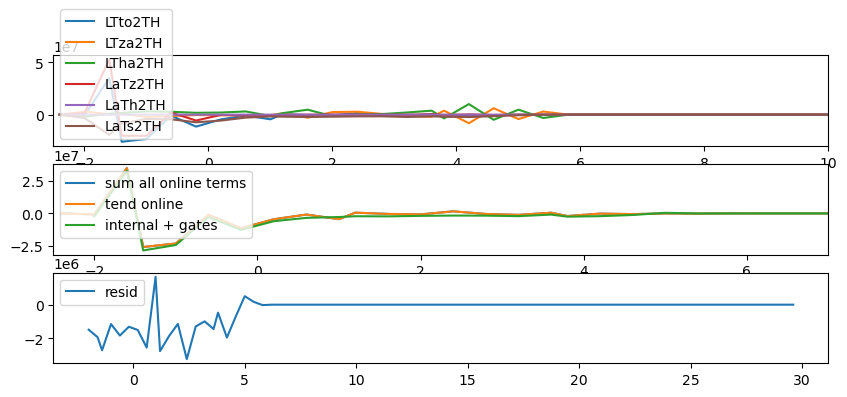

In [156]:
fig = plt.figure()

ax = plt.subplot(311)
for key in G_T[name][ts].keys():
    ax.plot(boundsT.flatten()[1:-1],G_T[name][ts][key],label=key)
ax.legend(loc="best")
ax.set_xlim(-2.5,10)

ax = plt.subplot(312)
sum = np.zeros_like(G_T[name][ts]['LTto2TH'])
for key in G_T[name][ts].keys():
    if key != 'LTto2TH':
        sum += G_T[name][ts][key]

ax.plot(boundsT.flatten()[1:-1],sum,label='sum all online terms')
ax.plot(boundsT.flatten()[1:-1],G_T[name][ts]['LTto2TH'],label='tend online')

advonline = G_T[name][ts]['LTza2TH'] + G_T[name][ts]['LTha2TH']
gates = G_FJNZ_vel + G_SPFJ_vel + G_NZRU_vel + G_BSO_vel # from the velmass terms
# gates = G_FJNZ + G_SPFJ + G_NZRU + G_BSO #

sumwgates = sum - advonline + gates #+ G_T[name][ts]['LTza2TH']
ax.plot(boundsT.flatten()[1:-1],sumwgates,label='internal + gates')

ax.legend(loc="best")
ax.set_xlim(-2.5,7)

ax = plt.subplot(313)

ax.plot(boundsT.flatten()[1:-1],sumwgates - G_T[name][ts]['LTto2TH'],label="resid")
ax.legend()

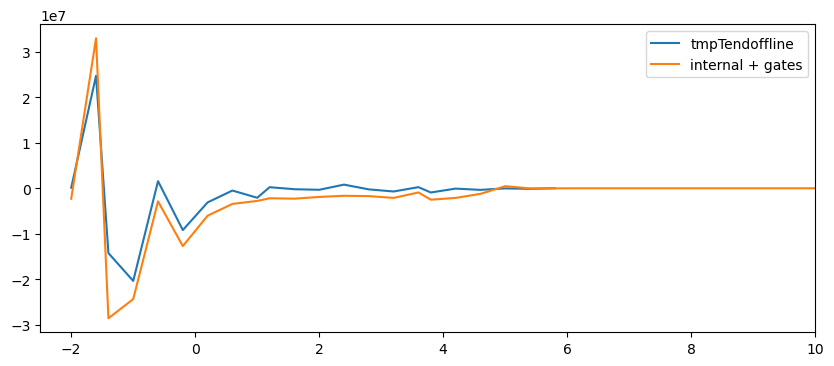

In [154]:
fig = plt.figure()

ax = plt.subplot(111)
ax.set_xlim(-2.5,10)

ax.plot(boundsT.flatten()[1:-1],tmptendT,label='tmpTendoffline')
ax.plot(boundsT.flatten()[1:-1],sumwgates,label='internal + gates')
ax.legend()



In [121]:
np.nansum(gates)

26773770.39964657

In [122]:
np.nansum(advonline)

28063461.494018495

In [123]:
print(G_T[name][ts].keys())

dict_keys(['LTto2TH', 'LTza2TH', 'LTha2TH', 'LaTz2TH', 'LaTh2TH', 'LaTs2TH'])


In [124]:
G_dfh = G_T[name][ts]['LaTh2TH']
G_dfr = G_T[name][ts]['LaTz2TH']
G_surf = G_T[name][ts]['LaTs2TH']

Text(0.5, 1.0, 'internal contributions')

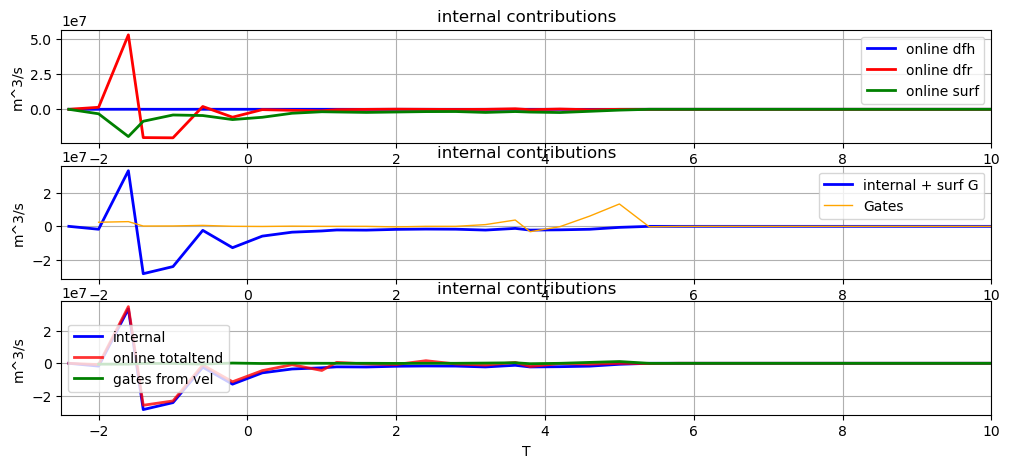

In [125]:
fig = plt.figure(figsize = (12,5))

ax = plt.subplot(311)

ax.plot(boundsT.flatten()[1:-1],G_dfh,linewidth=2,c="blue",label="online dfh")
ax.plot(boundsT.flatten()[1:-1],G_dfr,linewidth=2,c="red",label="online dfr")
ax.plot(boundsT.flatten()[1:-1],G_surf,linewidth=2,c="green",label="online surf")

ax.set_ylabel("m^3/s")
ax.set_xlabel("T")
ax.legend(loc="best")
ax.set_xlim(-2.5,10)
ax.grid()
plt.title("internal contributions")

ax = plt.subplot(312)
allgates = G_BSO + G_FJNZ + G_SPFJ + G_NZRU
ax.plot(boundsT.flatten()[1:-1],G_dfh + G_dfr + G_surf,linewidth=2,c="blue",label="internal + surf G")
ax.plot(boundsT.flatten()[1:-1], allgates, linewidth=1,c= "orange",label="Gates")
ax.set_ylabel("m^3/s")
ax.set_xlabel("T")
ax.legend(loc="best")
ax.set_xlim(-2.5,10)
ax.grid()
plt.title("internal contributions")

ax = plt.subplot(313)
ax.plot(boundsT.flatten()[1:-1],G_dfh + G_dfr + G_surf,linewidth=2,c="blue",label="internal")
# ax.plot(boundsT.flatten()[1:-1], G_total, linewidth=2,c= "red",label="LHS")
ax.plot(boundsT.flatten()[1:-1],totTtend,linewidth=2,c="red",label="online totaltend",alpha=0.8)
# ax.plot(boundsT.flatten()[1:-1],G_advh_online + G_T[name][ts]['LTza2TH'],linewidth=4,c="green",label="adv")
ax.plot(boundsT.flatten()[1:-1],G_BSO_vel + G_FJNZ_vel + G_SPFJ_vel + G_NZRU_vel,linewidth=2,c="green",label="gates from vel")


ax.set_ylabel("m^3/s")
ax.set_xlabel("T")
ax.legend(loc="best")
ax.set_xlim(-2.5,10)
ax.grid()
plt.title("internal contributions")

Text(0.5, 1.0, 'test volume convergence')

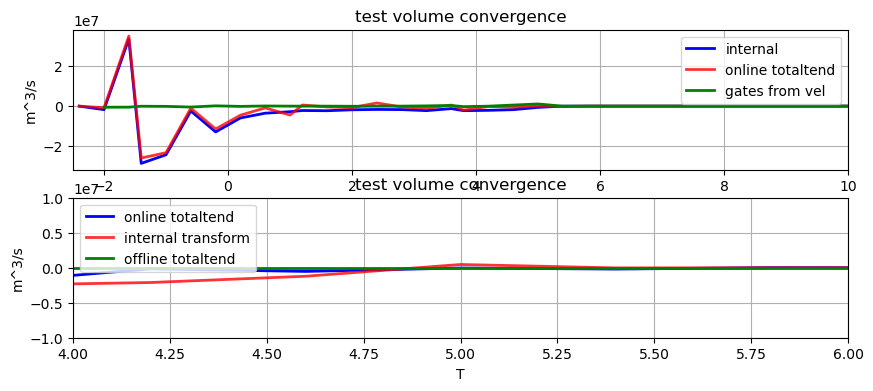

In [126]:
fig = plt.figure()

ax = plt.subplot(211)
ax.plot(boundsT.flatten()[1:-1],G_dfh + G_dfr + G_surf,linewidth=2,c="blue",label="internal")
ax.plot(boundsT.flatten()[1:-1],totTtend,linewidth=2,c="red",label="online totaltend",alpha=0.8)
ax.plot(boundsT.flatten()[1:-1],G_BSO_vel + G_FJNZ_vel + G_SPFJ_vel + G_NZRU_vel,linewidth=2,c="green",label="gates from vel")

ax.set_ylabel("m^3/s")
ax.set_xlabel("T")
ax.legend(loc="best")
ax.set_xlim(-2.5,10)
ax.grid()
plt.title("test volume convergence")


ax = plt.subplot(212)
testLHS = totTtend
testRHS = G_dfh + G_dfr + G_surf + G_BSO_vel + G_FJNZ_vel + G_SPFJ_vel + G_NZRU_vel

ax.plot(boundsT.flatten()[1:-1],testLHS,linewidth=2,c="blue",label="online totaltend")        # internal transformations + gates
ax.plot(boundsT.flatten()[1:-1],testRHS,linewidth=2,c="red",label="internal transform",alpha=0.8)     # total tend from layers
ax.plot(boundsT.flatten()[1:-1], G_total, linewidth=2,c= "green",label="offline totaltend")

ax.set_ylabel("m^3/s")
ax.set_xlabel("T")
ax.legend(loc="best")
ax.set_xlim(4,6)
ax.set_ylim(-1e7,1e7)
ax.grid()
plt.title("test volume convergence")


## Let's try to validate the LHS with dVdt/layers tend

In [128]:
totTtend = G_T[name][ts]['LTto2TH']

In [ ]:
# double check this is the same as the total dVdt of the basin




(-2.5, 10.0)

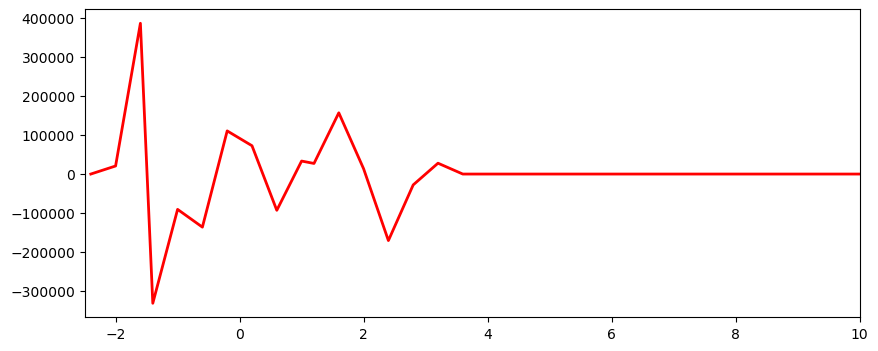

In [130]:
fig = plt.figure()

ax = plt.subplot(111)
# ax.plot(boundsT.flatten()[1:-1],totTtend,linewidth=2,c="blue",label="online totaltend",alpha=0.8)
ax.plot(boundsT.flatten()[1:-1], G_total, linewidth=2,c= "red",label="LHS")
ax.set_xlim(-2.5,10)


(-2.5, 10.0)

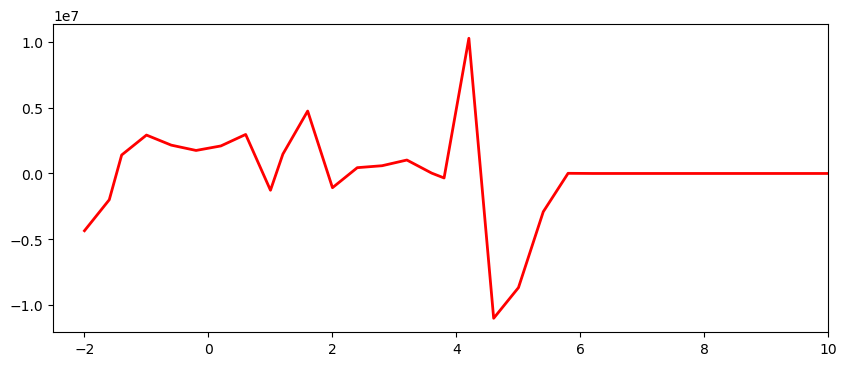

In [134]:
fig = plt.figure()

ax = plt.subplot(111)
ax.plot(boundsT.flatten()[1:-1], G_T[name][ts]['LTha2TH'] - (G_FJNZ + G_SPFJ + G_NZRU + G_BSO), linewidth=2,c= "red",label="LHS")
ax.set_xlim(-2.5,10)

(-2.5, 10.0)

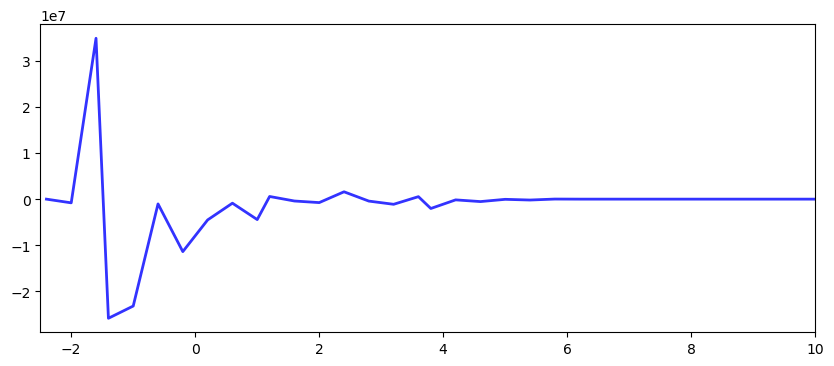

In [131]:
fig = plt.figure()

ax = plt.subplot(111)
ax.plot(boundsT.flatten()[1:-1],totTtend,linewidth=2,c="blue",label="online totaltend",alpha=0.8)
# ax.plot(boundsT.flatten()[1:-1], G_total, linewidth=2,c= "red",label="LHS")
ax.set_xlim(-2.5,10)


In [135]:
np.nansum(G_T[name][ts]['LTto2TH'])

-40061010.38904688

In [141]:
np.nansum(G_total*1e17)

432013312.0